## Code Illustration
Our Project code consists of three part. **Firstly**, we do some basic data cleaning and processing with class `PreProcessor`, which also gives inputs to generate training and testing data. **Then**, we will finish analysing part with class `Analyst`. **Finally,** we train models for each model family respectively.

## Pre-processing

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from typing import List
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
class PreProcessor:
    def __init__(self, file_path: str):
        """Initialize and read the data file"""
        self.data = pd.read_csv(file_path)
        self.train_data, self.test_data = None, None
        print("Data loaded successfully.")

    def getData(self):
        return self.data

    def getTrainData(self):
        return self.train_data

    def getTestData(self):
        return self.test_data

    def basicProcessing(self):
        """Perform basic cleaning: remove missing values, reset the index, encode categorical variables, and process the label column"""
        self.data.dropna(inplace=True)
        self.data.reset_index(drop=True, inplace=True)
        print("Missing values removed and index reset.")

        # Encode the `increase_stock` column
        label_mapping = {'low_bike_demand': 0, 'high_bike_demand': 1}
        self.data['increase_stock'] = self.data['increase_stock'].map(label_mapping)
        if self.data['increase_stock'].isnull().any():
            raise ValueError("Unknown labels in 'increase_stock'. Check data integrity.")
        print("Label column 'increase_stock' encoded successfully.")

    def describe(self):
        """Output basic statistical information about the data"""
        print(self.data.describe(include='all'))

    def drop_data(self, col_name: List[str] = None):
        """Drop specified columns from the dataset"""
        self.data.drop(columns=col_name, inplace=True)
        print(f"Columns {col_name} have been dropped from the dataset.")
        print(f"Updated dataset dimensions: {self.data.shape}")

    def categoryVar(self):
        """Encode categorical variables"""
        le = LabelEncoder()

        # Identify columns of type int64 as categorical variables
        cat_vars = self.data.select_dtypes(include=['int64']).columns

        for col in cat_vars:
            if col != 'increase_stock':  # Exclude the target variable, as it is also of type int64
                self.data[col] = le.fit_transform(self.data[col])

        print("Categorical variables transformed.")

    def categoryVar_onehot(self):
        """Perform One-Hot Encoding on categorical variables"""
        # Identify columns of type int64 or object as categorical variables
        cat_vars = self.data.select_dtypes(include=['int64']).columns

        # Exclude the target variable ('increase_stock') from encoding
        for col in cat_vars:
            if col != 'increase_stock':  # Exclude the target variable
                # Use pandas' get_dummies for One-Hot Encoding
                self.data = pd.get_dummies(self.data, columns=[col], drop_first=True)

        print("Categorical variables transformed using One-Hot Encoding.")

    def scaler(self):
        """Standardize numerical features"""
        scaler = StandardScaler()
        numeric_cols = self.data.select_dtypes(include=['float64']).columns
        self.data[numeric_cols] = scaler.fit_transform(self.data[numeric_cols])
        print("Numeric variables scaled.")

    def devideTrainingAndTesting(self, ration: float = 0.2):
        """Split the data into training and testing sets, with a default ratio of 8:2"""
        self.train_data, self.test_data = train_test_split(self.data, test_size=ration, random_state=42)

        # Print variable names
        print("Variables in the dataset:")
        print(list(self.data.columns))

        # Print the dimensions of the training and testing sets
        print(f"Training set size: {self.train_data.shape}")
        print(f"Testing set size: {self.test_data.shape}")
        print("Training and testing sets divided.")


## Initialization and dataset generation

In [4]:
preprocessor=PreProcessor('training_data_fall2024.csv')
preprocessor.basicProcessing()
preprocessor.describe()
preprocessor.drop_data(col_name='snow')
preprocessor.categoryVar()
preprocessor.devideTrainingAndTesting()

Data loaded successfully.
Missing values removed and index reset.
Label column 'increase_stock' encoded successfully.
       hour_of_day  day_of_week        month      holiday      weekday  \
count   1600.00000  1600.000000  1600.000000  1600.000000  1600.000000   
mean      11.37125     3.022500     6.468750     0.033125     0.710000   
std        6.94837     2.012965     3.454741     0.179019     0.453904   
min        0.00000     0.000000     1.000000     0.000000     0.000000   
25%        5.00000     1.000000     3.000000     0.000000     0.000000   
50%       12.00000     3.000000     6.000000     0.000000     1.000000   
75%       17.00000     5.000000     9.000000     0.000000     1.000000   
max       23.00000     6.000000    12.000000     1.000000     1.000000   

       summertime         temp          dew     humidity       precip    snow  \
count  1600.00000  1600.000000  1600.000000  1600.000000  1600.000000  1600.0   
mean      0.64375    15.210313     7.750750    63.927

In [5]:
# base data
Data=preprocessor.getData()
train_data,test_data=preprocessor.getTrainData(),preprocessor.getTestData()

X_train = train_data.drop('increase_stock', axis=1)
y_train = train_data['increase_stock']
X_test = test_data.drop('increase_stock', axis=1)
y_test = test_data['increase_stock']

In [6]:
# resampling data
from imblearn.over_sampling import SMOTE
from collections import Counter
# original distribution
print(f"Original class distribution: {Counter(y_train)}")

# initialization
smote = SMOTE(sampling_strategy=0.5, random_state=42)

# oversampling
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# resampled distribution
print(f"Resampled class distribution: {Counter(y_train_resampled)}")


Original class distribution: Counter({0: 1042, 1: 238})
Resampled class distribution: Counter({0: 1042, 1: 521})


In [7]:
# Function for feature engineering
def featureEngineering(X_train, X_test):
    ## Data augmentation and feature engineering
    X_train_new, X_test_new = X_train.copy(), X_test.copy()

    # Interaction terms between temperature and humidity
    X_train_new['temp_humidity_interaction'] = X_train_new['temp'] * X_train_new['humidity']
    X_test_new['temp_humidity_interaction'] = X_test_new['temp'] * X_test_new['humidity']

    # Interaction terms between dew point and humidity
    X_train_new['dew_humidity_interaction'] = X_train_new['dew'] * X_train_new['humidity']
    X_test_new['dew_humidity_interaction'] = X_test_new['dew'] * X_test_new['humidity']

    # Squared term of temperature
    X_train_new['temp_squared'] = X_train_new['temp'] ** 2
    X_test_new['temp_squared'] = X_test_new['temp'] ** 2

    # Log transformation for humidity
    X_train_new['humidity_log'] = np.log(X_train_new['humidity'])
    X_test_new['humidity_log'] = np.log(X_test_new['humidity'])

    ## Time-based feature segmentation
    ### 15-19: category 2; 0-7 and 21-23: category 0; others: category 1
    ### 0, 1, 11, 10: category 0; 2, 4, 6, 7: category 1; others: category 2

    # Segment time-based features
    X_train_new['hour_cate'] = 1  # Default value is 1
    X_train_new.loc[X_train_new['hour_of_day'].between(15, 19), 'hour_cate'] = 2  # 15-19 is category 2
    X_train_new.loc[(X_train_new['hour_of_day'] <= 7) | (X_train_new['hour_of_day'] >= 21), 'hour_cate'] = 0  # 0-7 and 21-23 are category 0

    X_test_new['hour_cate'] = 1  # Default value is 1
    X_test_new.loc[X_test_new['hour_of_day'].between(15, 19), 'hour_cate'] = 2
    X_test_new.loc[(X_test_new['hour_of_day'] <= 7) | (X_test_new['hour_of_day'] >= 21), 'hour_cate'] = 0

    # Segment month-based features
    X_train_new['month_cate'] = 2  # Default value is 2
    X_train_new.loc[X_train_new['month'].isin([0, 1, 10, 11]), 'month_cate'] = 0  # 0, 1, 10, 11 are category 0
    X_train_new.loc[X_train_new['month'].isin([2, 4, 6, 7]), 'month_cate'] = 1  # 2, 4, 6, 7 are category 1

    X_test_new['month_cate'] = 2  # Default value is 2
    X_test_new.loc[X_test_new['month'].isin([0, 1, 10, 11]), 'month_cate'] = 0
    X_test_new.loc[X_test_new['month'].isin([2, 4, 6, 7]), 'month_cate'] = 1

    # Process periodic features for hour, day of the week, and month
    X_train_new['hour_sin'] = np.sin(2 * np.pi * X_train_new['hour_of_day'] / 24)
    X_train_new['hour_cos'] = np.cos(2 * np.pi * X_train_new['hour_of_day'] / 24)

    X_train_new['day_of_week_sin'] = np.sin(2 * np.pi * X_train_new['day_of_week'] / 7)
    X_train_new['day_of_week_cos'] = np.cos(2 * np.pi * X_train_new['day_of_week'] / 7)

    X_train_new['month_sin'] = np.sin(2 * np.pi * X_train_new['month'] / 2)
    X_train_new['month_cos'] = np.cos(2 * np.pi * X_train_new['month'] / 2)

    X_test_new['hour_sin'] = np.sin(2 * np.pi * X_test_new['hour_of_day'] / 24)
    X_test_new['hour_cos'] = np.cos(2 * np.pi * X_test_new['hour_of_day'] / 24)

    X_test_new['day_of_week_sin'] = np.sin(2 * np.pi * X_test_new['day_of_week'] / 7)
    X_test_new['day_of_week_cos'] = np.cos(2 * np.pi * X_test_new['day_of_week'] / 7)

    X_test_new['month_sin'] = np.sin(2 * np.pi * X_test_new['month'] / 2)
    X_test_new['month_cos'] = np.cos(2 * np.pi * X_test_new['month'] / 2)

    # Drop the dew column
    X_train_new = X_train_new.drop('dew', axis=1)
    X_test_new = X_test_new.drop('dew', axis=1)

    return X_train_new, X_test_new


In [8]:
# new data: resamping and doing feature engineer on base data
X_train_new,X_test_new=featureEngineering(X_train_resampled, X_test)

In [9]:
# add data: only doing feature engineer on base data
X_train_add,X_test_add=featureEngineering(X_train, X_test)

## Analysing Tasks

In [ ]:
class Analyst:
    def __init__(self, processor: PreProcessor):
        """Initialize and load data file"""
        self.data = processor.getData()

    def scatterPlot(self):
        """Create a scatter plot matrix to explore correlations between variables"""
        sns.pairplot(self.data, diag_kind='kde')
        plt.show()

    def exploreTimeDemand(self):
        """Explore the relationship between demand and time"""
        print("Exploring demand and time relationships...")

        # Average demand per hour
        plt.figure(figsize=(10, 5))
        sns.lineplot(data=self.data, x='hour_of_day', y='increase_stock', estimator='mean', marker='o', ci=None)
        plt.title("Average Demand by Hour of Day")
        plt.xlabel("Hour of Day")
        plt.ylabel("Average Demand")
        plt.xticks(range(0, 24, 1))
        plt.show()

        # Demand distribution by day of the week
        # Uncomment the following lines to show why boxplot may not be ideal
        '''
        plt.figure(figsize=(8, 5))
        sns.boxplot(data=self.data, x='day_of_week', y='increase_stock')
        plt.title("Demand Distribution by Day of Week")
        plt.xlabel("Day of Week")
        plt.ylabel("Demand (0 or 1)")
        plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
        plt.show()
        '''
        plt.figure(figsize=(10, 5))
        sns.lineplot(data=self.data, x='day_of_week', y='increase_stock', estimator='mean', marker='o', ci=None)
        plt.title("Average Demand by Day of Week")
        plt.xlabel("Day of Week")
        plt.ylabel("Average Demand")
        plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
        plt.show()

        # Average demand per month
        plt.figure(figsize=(10, 5))
        sns.lineplot(data=self.data, x='month', y='increase_stock', estimator='mean', marker='o', ci=None)
        plt.title("Average Demand by Month")
        plt.xlabel("Month")
        plt.ylabel("Average Demand")
        plt.xticks(range(1, 13, 1))
        plt.show()

    def exploreSpecialTime(self):
        """Explore the impact of holidays, weekdays, and summer on demand"""

        # Extract required data columns
        holiday = self.data['holiday']
        weekday = self.data['weekday']
        label = self.data['increase_stock']

        # Calculate the number of increases and non-increases under various conditions
        holiday_increase = len(self.data[(holiday == 1) & (label == 1)])
        holiday_non_increase = len(self.data[(holiday == 1) & (label == 0)])
        non_holiday_increase = len(self.data[(holiday == 0) & (label == 1)])
        non_holiday_non_increase = len(self.data[(holiday == 0) & (label == 0)])

        weekday_increase = len(self.data[(weekday == 1) & (label == 1)])
        weekday_non_increase = len(self.data[(weekday == 1) & (label == 0)])
        non_weekday_increase = len(self.data[(weekday == 0) & (label == 1)])
        non_weekday_non_increase = len(self.data[(weekday == 0) & (label == 0)])

        # Format data for plotting
        labels = ['Holiday', 'Non-Holiday', 'Weekday', 'Non-Weekday']
        increase = [holiday_increase, non_holiday_increase, weekday_increase, non_weekday_increase]
        non_increase = [holiday_non_increase, non_holiday_non_increase, weekday_non_increase, non_weekday_non_increase]

        # Calculate percentages
        total_counts = [inc + non_inc for inc, non_inc in zip(increase, non_increase)]
        increase_perc = [inc / total * 100 for inc, total in zip(increase, total_counts)]
        non_increase_perc = [non_inc / total * 100 for non_inc, total in zip(non_increase, total_counts)]

        # Plot percentage stacked bar chart
        fig, ax = plt.subplots(figsize=(18, 6))

        y = np.arange(len(labels)) * 1.5
        width = 0.6

        ax.barh(y, increase_perc, width, color='#4169E1', label='Increase (%)')
        ax.barh(y, non_increase_perc, width, left=increase_perc, color='#C0C0C0', label='Non-Increase (%)')

        ax.set_yticks(y)
        ax.set_yticklabels(labels)
        ax.set_xlabel('Percentage')
        ax.set_ylabel('Condition')
        ax.set_title('Impact of Special Times on Increase')
        ax.legend()

        # Add values: adjust text position to avoid overlap
        for i, (inc, non_inc, total, inc_p, non_inc_p) in enumerate(zip(increase, non_increase, total_counts, increase_perc, non_increase_perc)):
            if inc_p < 10:  # Move text outside short bars
                ax.text(inc_p + 1, y[i], f'{inc:.0f} ({inc_p:.1f}%)', ha='left', va='center', fontsize=10)
            else:
                ax.text(inc_p / 2, y[i], f'{inc:.0f} ({inc_p:.1f}%)', ha='center', va='center', color='white', fontsize=10)

            if non_inc_p < 10:
                ax.text(inc_p + non_inc_p + 1, y[i], f'{non_inc:.0f} ({non_inc_p:.1f}%)', ha='left', va='center', fontsize=10)
            else:
                ax.text(inc_p + non_inc_p / 2, y[i], f'{non_inc:.0f} ({non_inc_p:.1f}%)', ha='center', va='center', fontsize=10)

        # Adjust layout
        plt.tight_layout()
        plt.show()

    def exploreWeatherType(self):
        """Explore the impact of summer, rain, and snow on demand with a percentage-stacked bar chart."""

        # Extract relevant data columns
        summer = self.data['summertime']
        precip = self.data['precip']
        snow = self.data['snowdepth']
        label = self.data['increase_stock']

        # Calculate the count of increase and non-increase under different weather conditions
        summer_increase = len(self.data[(summer == 1) & (label == 1)])
        summer_non_increase = len(self.data[(summer == 1) & (label == 0)])
        non_summer_increase = len(self.data[(summer == 0) & (label == 1)])
        non_summer_non_increase = len(self.data[(summer == 0) & (label == 0)])

        precip_increase = len(self.data[(precip > 0) & (label == 1)])
        precip_non_increase = len(self.data[(precip > 0) & (label == 0)])
        non_precip_increase = len(self.data[(precip == 0) & (label == 1)])
        non_precip_non_increase = len(self.data[(precip == 0) & (label == 0)])

        snow_increase = len(self.data[(snow > 0) & (label == 1)])
        snow_non_increase = len(self.data[(snow > 0) & (label == 0)])
        non_snow_increase = len(self.data[(snow == 0) & (label == 1)])
        non_snow_non_increase = len(self.data[(snow == 0) & (label == 0)])

        # Organize data for plotting
        labels = ['Summer', 'Non-Summer', 'Precip', 'Non-Precip', 'Snow', 'Non-Snow']
        increase = [summer_increase, non_summer_increase, precip_increase, non_precip_increase, snow_increase, non_snow_increase]
        non_increase = [summer_non_increase, non_summer_non_increase, precip_non_increase, non_precip_non_increase, snow_non_increase, non_snow_non_increase]

        # Calculate percentages
        total_counts = [inc + non_inc for inc, non_inc in zip(increase, non_increase)]
        increase_perc = [inc / total * 100 for inc, total in zip(increase, total_counts)]
        non_increase_perc = [non_inc / total * 100 for non_inc, total in zip(non_increase, total_counts)]

        # Create percentage-stacked bar chart
        fig, ax = plt.subplots(figsize=(18, 6))

        y = np.arange(len(labels)) * 1.5
        width = 0.6

        ax.barh(y, increase_perc, width, color='#4169E1', label='Increase (%)')
        ax.barh(y, non_increase_perc, width, left=increase_perc, color='#C0C0C0', label='Non-Increase (%)')

        ax.set_yticks(y)
        ax.set_yticklabels(labels)
        ax.set_xlabel('Percentage')
        ax.set_ylabel('Weather Condition')
        ax.set_title('Weather Impact on Increase')
        ax.legend()

        # Add annotations: adjust text position to avoid overlap
        for i, (inc, non_inc, total, inc_p, non_inc_p) in enumerate(zip(increase, non_increase, total_counts, increase_perc, non_increase_perc)):
            if inc_p < 10:  # If the bar is too short, place the text outside
                ax.text(inc_p + 1, y[i], f'{inc:.0f} ({inc_p:.1f}%)', ha='left', va='center', fontsize=10)
            else:
                ax.text(inc_p / 2, y[i], f'{inc:.0f} ({inc_p:.1f}%)', ha='center', va='center', color='white', fontsize=10)

            if non_inc_p < 10:
                ax.text(inc_p + non_inc_p + 1, y[i], f'{non_inc:.0f} ({non_inc_p:.1f}%)', ha='left', va='center', fontsize=10)
            else:
                ax.text(inc_p + non_inc_p / 2, y[i], f'{non_inc:.0f} ({non_inc_p:.1f}%)', ha='center', va='center', fontsize=10)

        # Adjust layout
        plt.tight_layout()
        plt.show()

    def exploreWeatherDemand(self):
        """Further explore the relationship between demand and weather features."""
        print("Exploring demand and weather relationships...")
        weather_vars = ['temp', 'dew', 'humidity', 'precip', 'snowdepth', 'windspeed', 'cloudcover', 'visibility']
        log_scale_cols = ['Precip', 'snowDepth', 'windspeed', 'visibility']

        # Loop through each weather variable and plot boxplots
        for var in weather_vars:
            plt.figure(figsize=(8, 5))
            if var in log_scale_cols:
                data_copy = self.data.copy()
                data_copy[var] = data_copy[var].apply(lambda x: np.nan if x <= 0 else x)
                sns.boxplot(data=data_copy, x='increase_stock', y=var)
                plt.yscale('log')
                plt.ylabel(f"{var.capitalize()} (Log Scale)")
            else:
                sns.boxplot(data=self.data, x='increase_stock', y=var)
                plt.ylabel(var.capitalize())

            plt.title(f"{var.capitalize()} by Demand (0 or 1)")
            plt.xlabel("Demand (0 or 1)")
            plt.show()

    def exploreWeatherDemand_violin(self):
        """Visualize the standardized impact of weather variables on demand using violin plots."""
        from sklearn.preprocessing import StandardScaler

        weather_vars = ['temp', 'dew', 'humidity', 'precip', 'snowdepth', 'windspeed', 'cloudcover', 'visibility']

        # Standardize data
        data_copy = self.data.copy()
        scaler = StandardScaler()
        data_copy[weather_vars] = scaler.fit_transform(data_copy[weather_vars])

        # Reshape the dataframe for Seaborn
        melted_data = data_copy.melt(id_vars=['increase_stock'], value_vars=weather_vars,
                                    var_name='Weather Variable', value_name='Standardized Value')

        # Create facet grid for violin plots
        g = sns.FacetGrid(melted_data, col="Weather Variable", col_wrap=4, height=4, sharey=True)
        g.map(
            sns.violinplot,
            "increase_stock",
            "Standardized Value",
            order=[0, 1],
            split=True,
            scale="width",
            inner="quartile",
            palette={"0": "#C0C0C0", "1": "#4169E1"}
        )
        g.set_titles("{col_name}")
        g.set_axis_labels("Demand (0 or 1)", "Standardized Value")
        g.fig.suptitle("Weather Variables' Standardized Impact by Demand", y=1.02)
        plt.tight_layout()
        plt.show()

    def exploreMulticollinearity(self):
        """Explore multicollinearity: Correlation heatmap and Variance Inflation Factor (VIF)."""
        weather_vars = ['temp', 'dew', 'humidity', 'precip', 'snowdepth', 'windspeed', 'cloudcover', 'visibility']

        # Customize color mapping
        custom_cmap = sns.diverging_palette(240, 240, s=80, l=55, as_cmap=True)  # Based on blue and gray

        # Correlation heatmap
        plt.figure(figsize=(6, 4))
        sns.heatmap(
            self.data[weather_vars].corr(),
            annot=True,
            cmap=custom_cmap,
            fmt=".2f",
            cbar_kws={'label': 'Correlation Coefficient'},
            linewidths=0.5
        )
        plt.title("Correlation Heatmap: Numerical Variables", fontsize=10)
        plt.xticks(rotation=45, fontsize=10)
        plt.yticks(fontsize=10)
        plt.tight_layout()
        plt.show()

        # Calculate Variance Inflation Factor (VIF)
        from statsmodels.stats.outliers_influence import variance_inflation_factor
        vif_data = pd.DataFrame()
        vif_data['Feature'] = weather_vars
        vif_data['VIF'] = [
            variance_inflation_factor(self.data[weather_vars].dropna().values, i)
            for i in range(len(weather_vars))
        ]
        print("Variance Inflation Factors (VIF):")
        print(vif_data)




In [ ]:
# Initialization
analyst=Analyst(preprocessor)

In [ ]:
# check label ditribution
analyst.data['increase_stock'].value_counts(normalize=True)

,proportion
increase_stock,
0,0.82
1,0.18


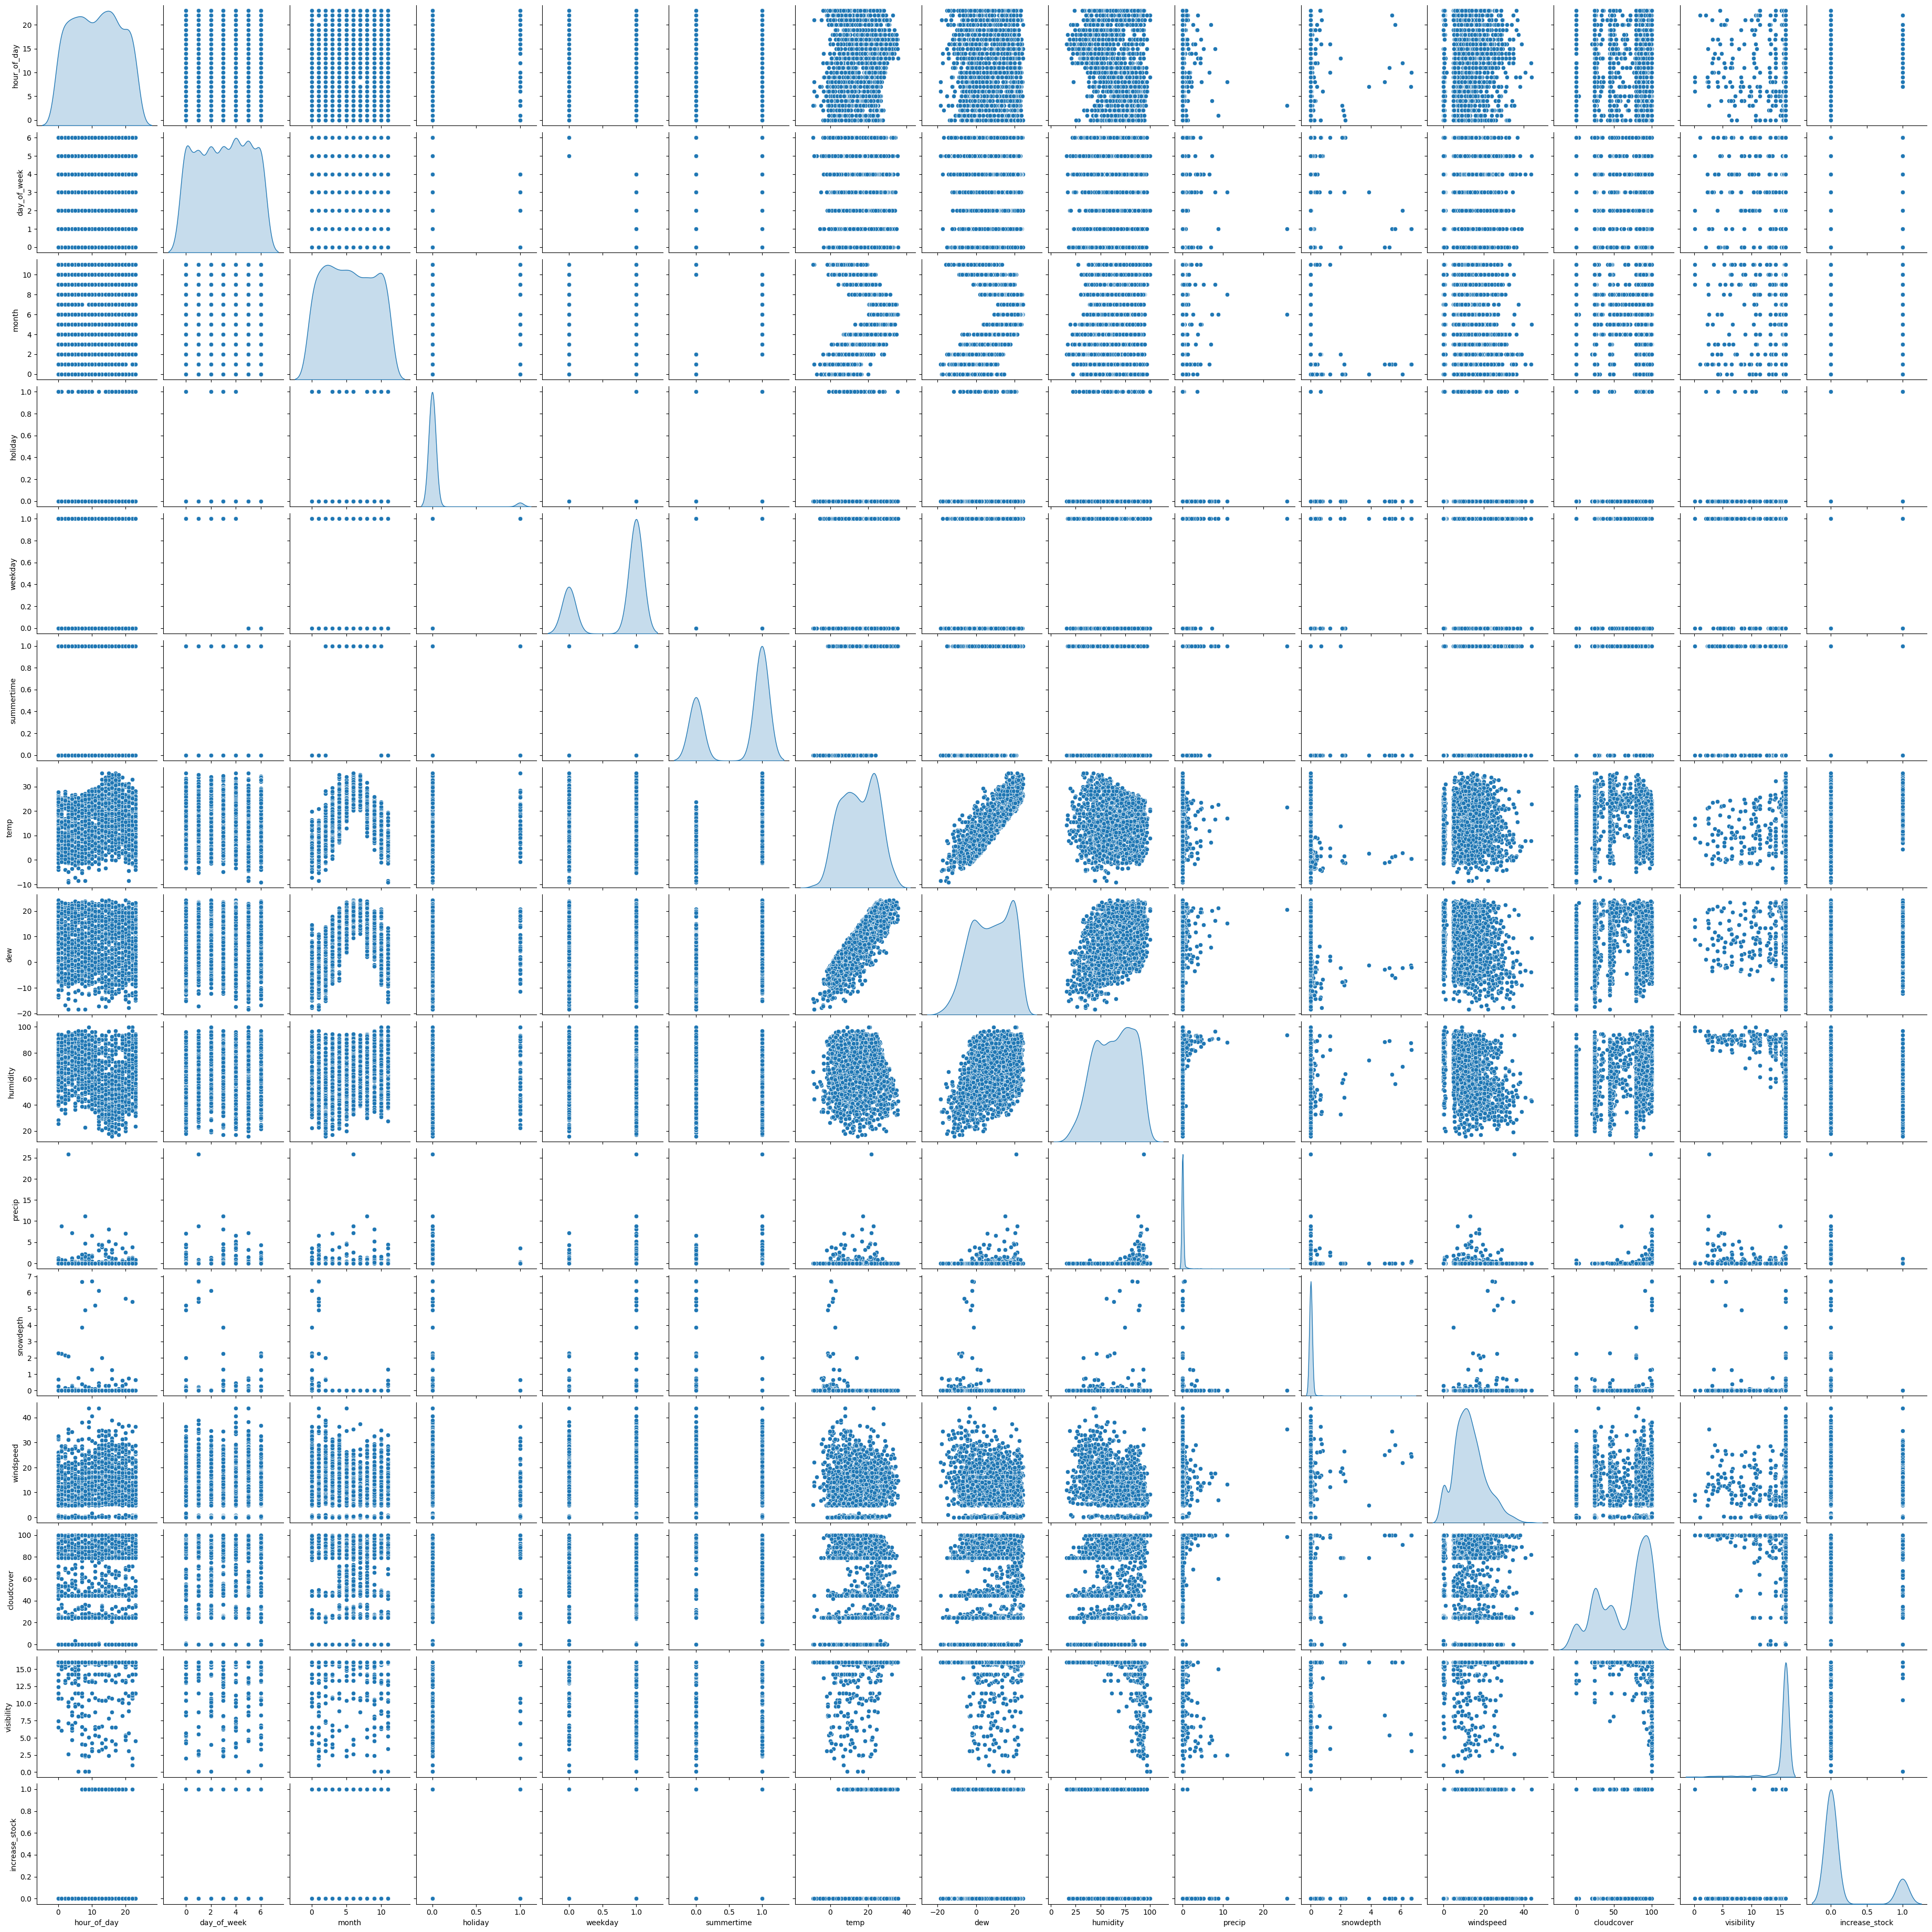

In [ ]:
# check all variables's distribution
analyst.scatterPlot()

Exploring demand and time relationships...


<ipython-input-12-582fecd1a8b5>:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=self.data, x='hour_of_day', y='increase_stock', estimator='mean', marker='o', ci=None)


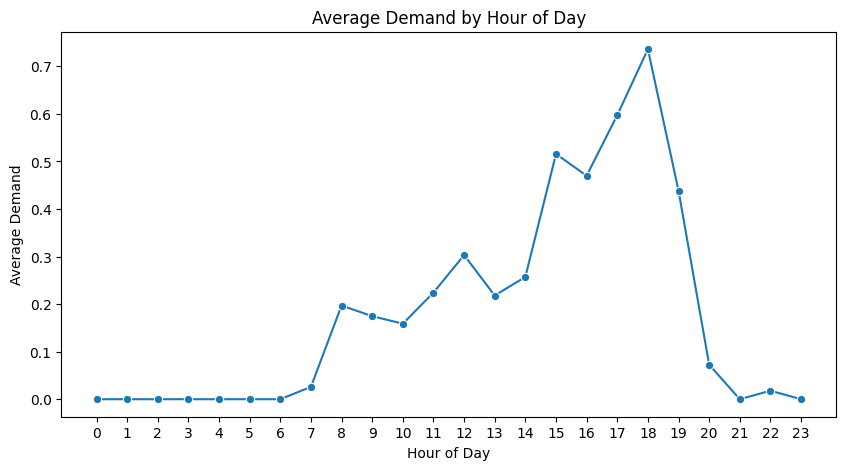

<ipython-input-12-582fecd1a8b5>:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=self.data, x='day_of_week', y='increase_stock', estimator='mean', marker='o', ci=None)


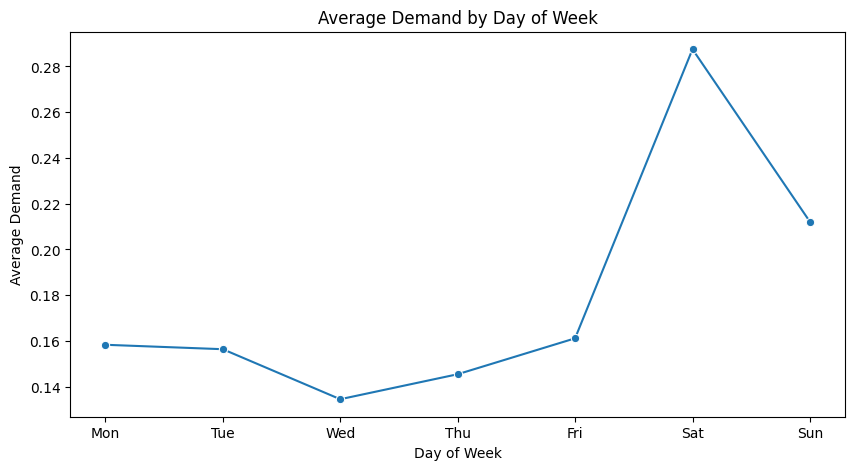

<ipython-input-12-582fecd1a8b5>:45: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=self.data, x='month', y='increase_stock', estimator='mean', marker='o', ci=None)


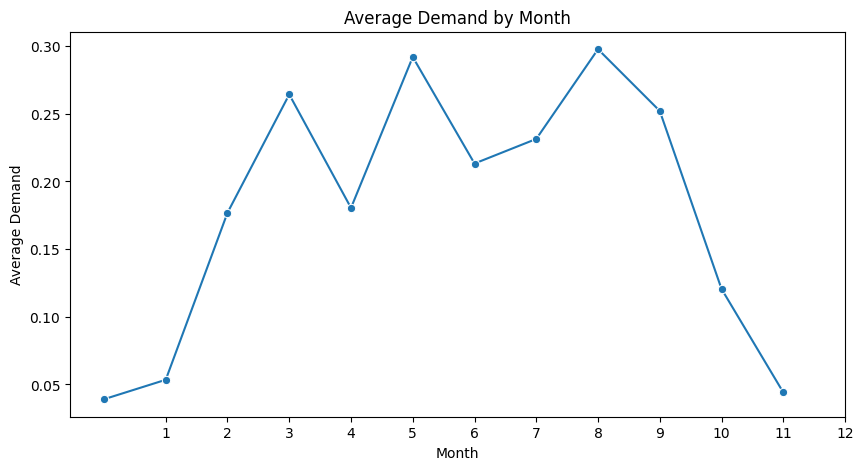

In [ ]:
# explore how demand varies with time
analyst.exploreTimeDemand()

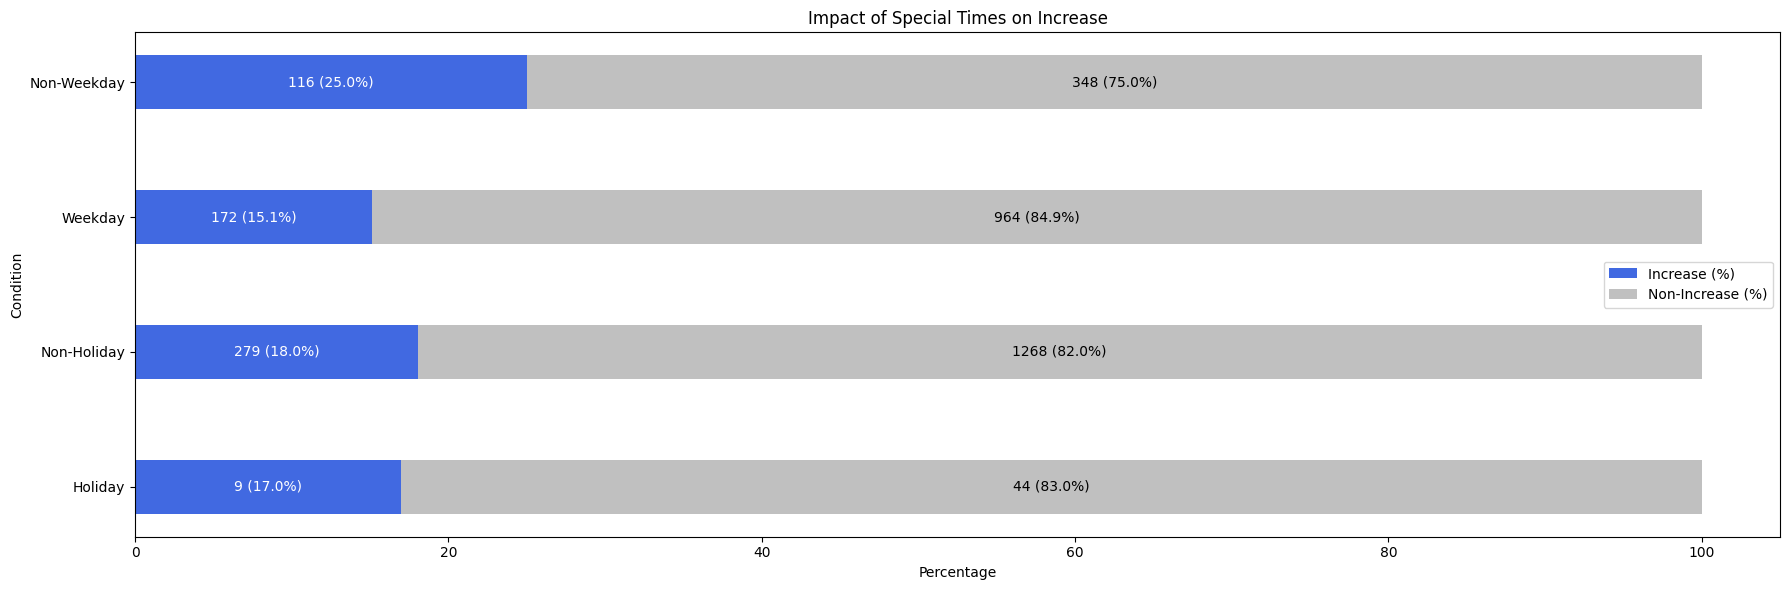

In [ ]:
# explore special time impact on demand
analyst.exploreSpecialTime()

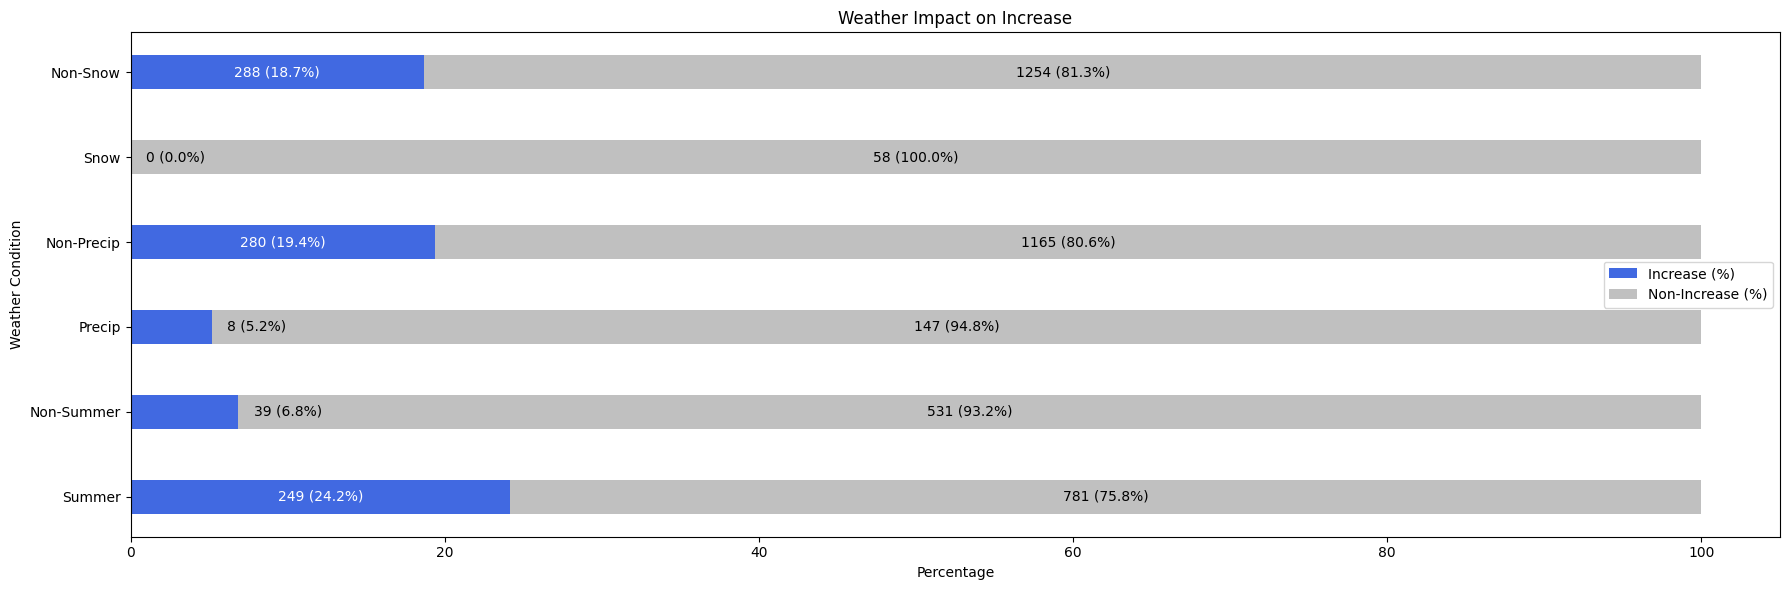

In [ ]:
# explore weather impact on demand
analyst.exploreWeatherType()

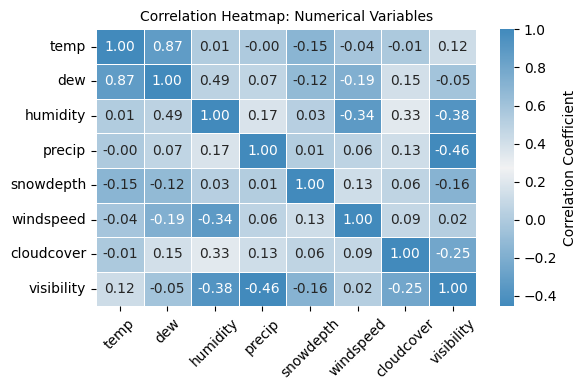

Variance Inflation Factors (VIF):
      Feature        VIF
0        temp  45.495437
1         dew  24.823404
2    humidity  31.761317
3      precip   1.286548
4   snowdepth   1.079373
5   windspeed   4.601968
6  cloudcover   5.835348
7  visibility  50.249163


In [ ]:
# correlationship exploration
analyst.exploreMulticollinearity()

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect

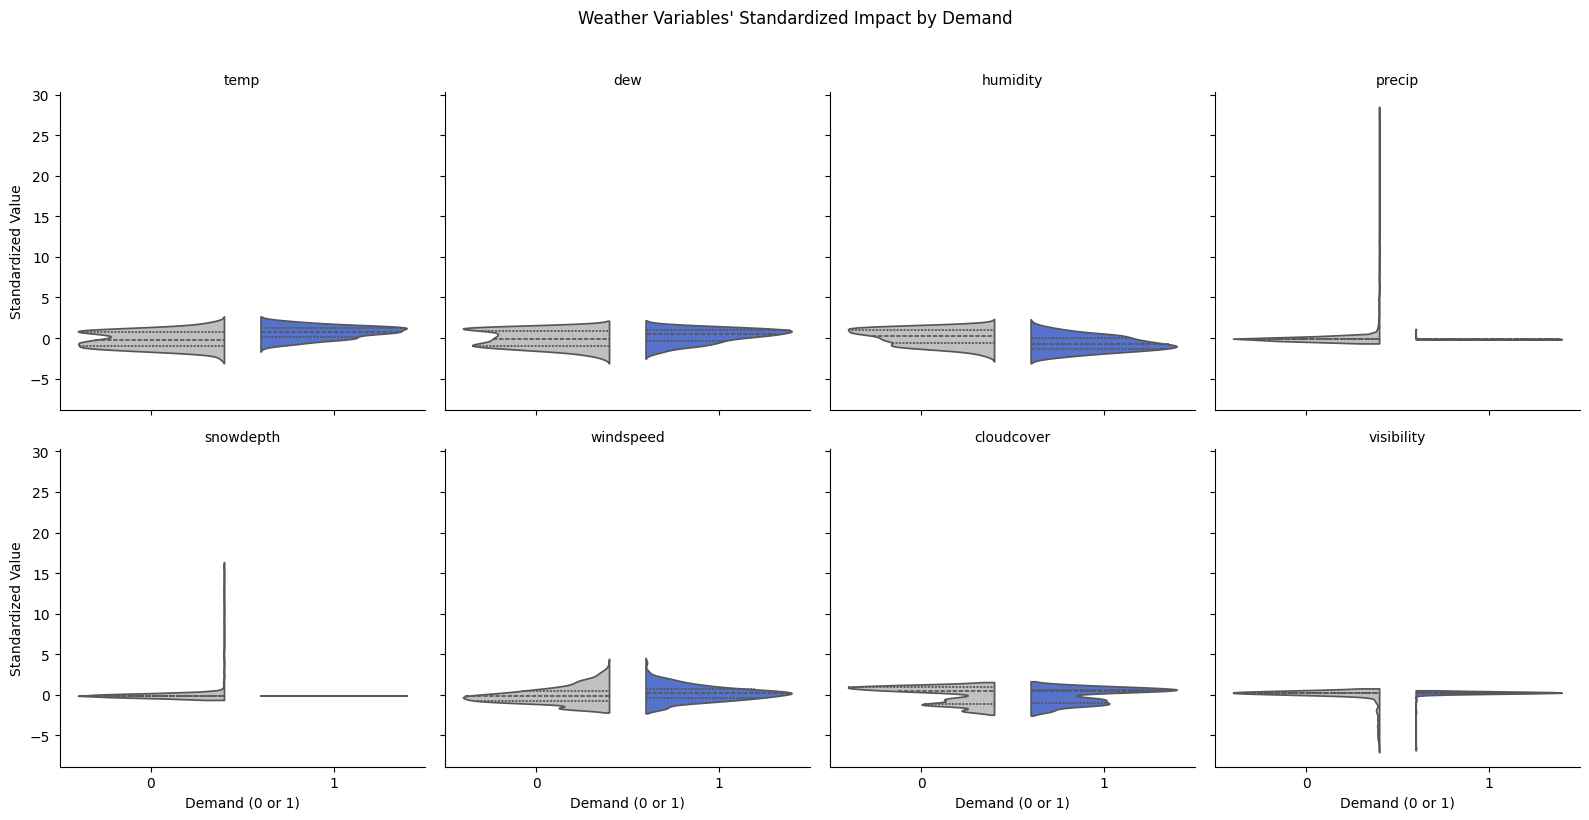

In [ ]:
# outlier detection
analyst.exploreWeatherDemand_violin()

# Model Training
Here we train different models from each family on 4 dataset(base, resampling,new,add). Then we choose the best performed one after tuning each model to its best parameters combination.

In [10]:
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.base import BaseEstimator

In [11]:
## evaluation
def test(model,X_train, y_train,X_test,y_test):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        return model

## Benchmark: an naive prodiction model which will only output 0

In [ ]:
class AlwaysZeroModel(BaseEstimator):
    def fit(self, X, y):
        # we have no training process
        pass

    def predict(self, X):
        # always output 0
        return np.zeros(X.shape[0], dtype=int)

In [ ]:
benchmark = AlwaysZeroModel()
test(benchmark, X_train, y_train, X_test, y_test)

Accuracy: 0.84375
Confusion Matrix:
[[270   0]
 [ 50   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.92       270
           1       0.00      0.00      0.00        50

    accuracy                           0.84       320
   macro avg       0.42      0.50      0.46       320
weighted avg       0.71      0.84      0.77       320



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AlwaysZeroModel()

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
import warnings

In [ ]:
def evaluate_clf_model(X,y, X_test):
    """
    Evaluates a classification model using GridSearchCV for hyperparameter tuning,
    trains the model with the best parameters, and prints evaluation metrics.

    Args:
        X (pd.DataFrame): The training data features.
        y (pd.Series): The training data target variable.
        X_test (pd.DataFrame): The testing data features.

    Returns:
        tuple: A tuple containing the trained model and the predicted labels for the test set.
    """
    warnings.filterwarnings('ignore')
    # 超参数优化
    param_grid = {'C': [1, 5, 10, 15], 'penalty': ['l1', 'l2'], 'solver':['liblinear', 'lbfgs', 'saga']}
    grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X, y)
    print("Best Parameters:", grid_search.best_params_)
    print("Best Cross-Validation Accuracy:", grid_search.best_score_)
    # 打印超参数优化后的报告
    LR_model = grid_search.best_estimator_
    y_pred = LR_model.predict(X_test)

    print("Model Performance:")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))


    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df = report_df.round(3)

    print("Classification Report:")
    print(report_df)
    # print("Classification Report:")
    # print(classification_report(y_test, y_pred))

    return LR_model, y_pred

In [ ]:
# training set:X_train,y_train
LRmodel_clf_0, y_LRmodel_pre_0 = evaluate_clf_model(X_train, y_train, X_test)

Best Parameters: {'C': 15, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.85078125
Model Performance:
Confusion Matrix:
[[248  22]
 [ 29  21]]
Classification Report:
              precision  recall  f1-score  support
0                 0.895   0.919     0.907  270.000
1                 0.488   0.420     0.452   50.000
accuracy          0.841   0.841     0.841    0.841
macro avg         0.692   0.669     0.679  320.000
weighted avg      0.832   0.841     0.836  320.000


In [ ]:
# training set:X_train_resampled,y_train_resampled
LRmodel_clf_resampled, y_LRmodel_pred_resampled = evaluate_clf_model(X_train_resampled, y_train_resampled, X_test)

Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Cross-Validation Accuracy: 0.8311173916605228
Model Performance:
Confusion Matrix:
[[227  43]
 [ 20  30]]
Classification Report:
              precision  recall  f1-score  support
0                 0.919   0.841     0.878  270.000
1                 0.411   0.600     0.488   50.000
accuracy          0.803   0.803     0.803    0.803
macro avg         0.665   0.720     0.683  320.000
weighted avg      0.840   0.803     0.817  320.000


In [ ]:
# training set:X_train_new,y_train_resampled,X_test_new
LRmodel_clf_new, y_LRmodel_pred_new = evaluate_clf_model(X_train_new, y_train_resampled, X_test_new)

Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.8983103956746129
Model Performance:
Confusion Matrix:
[[237  33]
 [ 13  37]]
Classification Report:
              precision  recall  f1-score  support
0                 0.948   0.878     0.912  270.000
1                 0.529   0.740     0.617   50.000
accuracy          0.856   0.856     0.856    0.856
macro avg         0.738   0.809     0.764  320.000
weighted avg      0.882   0.856     0.865  320.000


In [ ]:
# training set:X_train_add,y_train,X_test_add
LRmodel_clf_add, y_LRmodel_pred_add = evaluate_clf_model(X_train_add, y_train, X_test_add)

Best Parameters: {'C': 15, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.9015625
Model Performance:
Confusion Matrix:
[[244  26]
 [ 17  33]]
Classification Report:
              precision  recall  f1-score  support
0                 0.935   0.904     0.919  270.000
1                 0.559   0.660     0.606   50.000
accuracy          0.866   0.866     0.866    0.866
macro avg         0.747   0.782     0.762  320.000
weighted avg      0.876   0.866     0.870  320.000


## LDA & QDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

In [ ]:
# LDA model with basic data
lda_base = LinearDiscriminantAnalysis()
print("LDA Model Performance:")
lda_accuracy = test(lda_base, X_train, y_train, X_test, y_test)

# QDA model with basic data
qda_base = QuadraticDiscriminantAnalysis()
print("\nQDA Model Performance:")
qda_accuracy = test(qda_base, X_train, y_train, X_test, y_test)

LDA Model Performance:
Evaluating model: LinearDiscriminantAnalysis
Confusion Matrix:
[[247  23]
 [ 29  21]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       270
           1       0.48      0.42      0.45        50

    accuracy                           0.84       320
   macro avg       0.69      0.67      0.68       320
weighted avg       0.83      0.84      0.83       320

Accuracy: 0.8375

QDA Model Performance:
Evaluating model: QuadraticDiscriminantAnalysis
Confusion Matrix:
[[ 17 253]
 [  0  50]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.06      0.12       270
           1       0.17      1.00      0.28        50

    accuracy                           0.21       320
   macro avg       0.58      0.53      0.20       320
weighted avg       0.87      0.21      0.14       320

Accuracy: 0.2094


In [ ]:
# LDA model with resampled data
lda_resampled = LinearDiscriminantAnalysis()
print("LDA Model Performance:")
lda_accuracy = test(lda_resampled, X_train_resampled, y_train_resampled, X_test, y_test)

# QDA model with resampled data
qda_resampled = QuadraticDiscriminantAnalysis()
print("\nQDA Model Performance:")
qda_accuracy = test(qda_resampled, X_train_resampled, y_train_resampled, X_test, y_test)


LDA Model Performance:
Evaluating model: LinearDiscriminantAnalysis
Confusion Matrix:
[[227  43]
 [ 19  31]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       270
           1       0.42      0.62      0.50        50

    accuracy                           0.81       320
   macro avg       0.67      0.73      0.69       320
weighted avg       0.84      0.81      0.82       320

Accuracy: 0.8063

QDA Model Performance:
Evaluating model: QuadraticDiscriminantAnalysis
Confusion Matrix:
[[ 53 217]
 [  3  47]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.20      0.33       270
           1       0.18      0.94      0.30        50

    accuracy                           0.31       320
   macro avg       0.56      0.57      0.31       320
weighted avg       0.83      0.31      0.32       320

Accuracy: 0.3125


In [ ]:
# LDA model with new data
lda_resample_features = LinearDiscriminantAnalysis()
print("\nLDA Model Performance:")
lda_accuracy = test(lda_resample_features, X_train_new, y_train_resampled, X_test_new, y_test)

# QDA model with new data
qda_resample_features = QuadraticDiscriminantAnalysis()
print("\nQDA Model Performance:")
qda_accuracy = test(qda_resample_features, X_train_new, y_train_resampled, X_test_new, y_test)


LDA Model Performance:
Evaluating model: LinearDiscriminantAnalysis
Confusion Matrix:
[[235  35]
 [ 15  35]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90       270
           1       0.50      0.70      0.58        50

    accuracy                           0.84       320
   macro avg       0.72      0.79      0.74       320
weighted avg       0.87      0.84      0.85       320

Accuracy: 0.8438

QDA Model Performance:
Evaluating model: QuadraticDiscriminantAnalysis
Confusion Matrix:
[[269   1]
 [ 50   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       270
           1       0.00      0.00      0.00        50

    accuracy                           0.84       320
   macro avg       0.42      0.50      0.46       320
weighted avg       0.71      0.84      0.77       320

Accuracy: 0.8406


In [ ]:
# LDA model with add data
lda_features = LinearDiscriminantAnalysis()
print("\nLDA Model Performance:")
lda_accuracy = test(lda_features, X_train_add, y_train, X_test_add, y_test)

# QDA model with add data
qda_features = QuadraticDiscriminantAnalysis()
print("\nQDA Model Performance:")
qda_accuracy = test(qda_features, X_train_add, y_train, X_test_add, y_test)


LDA Model Performance:
Evaluating model: LinearDiscriminantAnalysis
Confusion Matrix:
[[243  27]
 [ 22  28]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       270
           1       0.51      0.56      0.53        50

    accuracy                           0.85       320
   macro avg       0.71      0.73      0.72       320
weighted avg       0.85      0.85      0.85       320

Accuracy: 0.8469

QDA Model Performance:
Evaluating model: QuadraticDiscriminantAnalysis
Confusion Matrix:
[[219  51]
 [ 10  40]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.81      0.88       270
           1       0.44      0.80      0.57        50

    accuracy                           0.81       320
   macro avg       0.70      0.81      0.72       320
weighted avg       0.88      0.81      0.83       320

Accuracy: 0.8094


In [ ]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# LDA model with standardized basic data
lda_model_standard = LinearDiscriminantAnalysis()
print("LDA Model Performance:")
lda_accuracy = test(lda_model_standard, X_train_scaled, y_train, X_test_scaled, y_test)

# QDA model with standardized basic data
qda_model_standard = QuadraticDiscriminantAnalysis()
print("\nQDA Model Performance:")
qda_accuracy = test(qda_model_standard, X_train_scaled, y_train, X_test_scaled, y_test)

LDA Model Performance:
Evaluating model: LinearDiscriminantAnalysis
Confusion Matrix:
[[247  23]
 [ 29  21]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       270
           1       0.48      0.42      0.45        50

    accuracy                           0.84       320
   macro avg       0.69      0.67      0.68       320
weighted avg       0.83      0.84      0.83       320

Accuracy: 0.8375

QDA Model Performance:
Evaluating model: QuadraticDiscriminantAnalysis
Confusion Matrix:
[[ 17 253]
 [  0  50]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.06      0.12       270
           1       0.17      1.00      0.28        50

    accuracy                           0.21       320
   macro avg       0.58      0.53      0.20       320
weighted avg       0.87      0.21      0.14       320

Accuracy: 0.2094


## KNN

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=10)
test(knn, X_train, y_train, X_test, y_test)

Confusion Matrix:
[[250  20]
 [ 36  14]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       270
           1       0.41      0.28      0.33        50

    accuracy                           0.82       320
   macro avg       0.64      0.60      0.62       320
weighted avg       0.80      0.82      0.81       320

Accuracy: 0.8250


In [ ]:
### Standardize the data, k=10
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

k = 10

knn_standard = KNeighborsClassifier(n_neighbors=k)
test(knn_standard, X_train_scaled, y_train, X_test_scaled, y_test)

Confusion Matrix:
[[250  20]
 [ 36  14]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       270
           1       0.41      0.28      0.33        50

    accuracy                           0.82       320
   macro avg       0.64      0.60      0.62       320
weighted avg       0.80      0.82      0.81       320

Accuracy: 0.8250


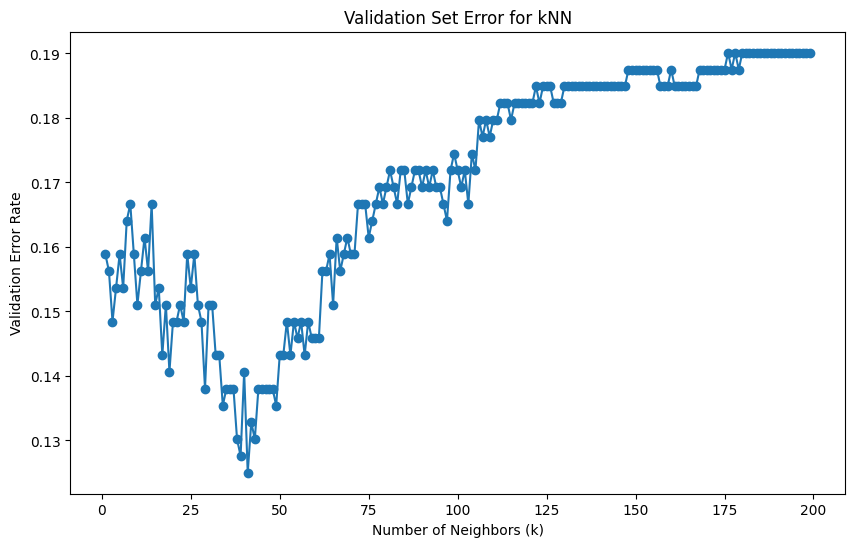

best k: 41
Confusion Matrix:
[[254  16]
 [ 37  13]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.91       270
           1       0.45      0.26      0.33        50

    accuracy                           0.83       320
   macro avg       0.66      0.60      0.62       320
weighted avg       0.81      0.83      0.82       320

Accuracy: 0.8344


In [ ]:
### find k, kNN_base

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Randomly split the training set into training and validation sets
np.random.seed(1)
N = len(X_train)
M = int(np.ceil(0.7 * N))
idx = np.random.permutation(N)

# Split the dataset
X_train_split = X_train_scaled[idx[:M], :]
X_val_split = X_train_scaled[idx[M:], :]
y_train_split = y_train.iloc[idx[:M]]
y_val_split = y_train.iloc[idx[M:]]

# Find the optimal K value
misclassification = []
K = np.arange(1, 200)  # try k = 1, 2, ..., 199

for k in K:
    kNN_base = KNeighborsClassifier(n_neighbors=k)
    kNN_base.fit(X_train_split, y_train_split)
    prediction = kNN_base.predict(X_val_split)
    misclassification.append(np.mean(prediction != y_val_split))

# Plot the relationship between validation error and K
plt.figure(figsize=(10, 6))
plt.plot(K, misclassification, marker='o')
plt.title('Validation Set Error for kNN')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Validation Error Rate')
plt.show()

best_k = K[np.argmin(misclassification)]
print(f"best k: {best_k}")

# Train and evaluate the model with the optimal k
knn_best_base = KNeighborsClassifier(n_neighbors=best_k)
knn_best_base.fit(X_train_scaled, y_train)

y_pred = knn_best_base.predict(X_test_scaled)

test(knn_best_base, X_train_scaled, y_train, X_test_scaled, y_test)

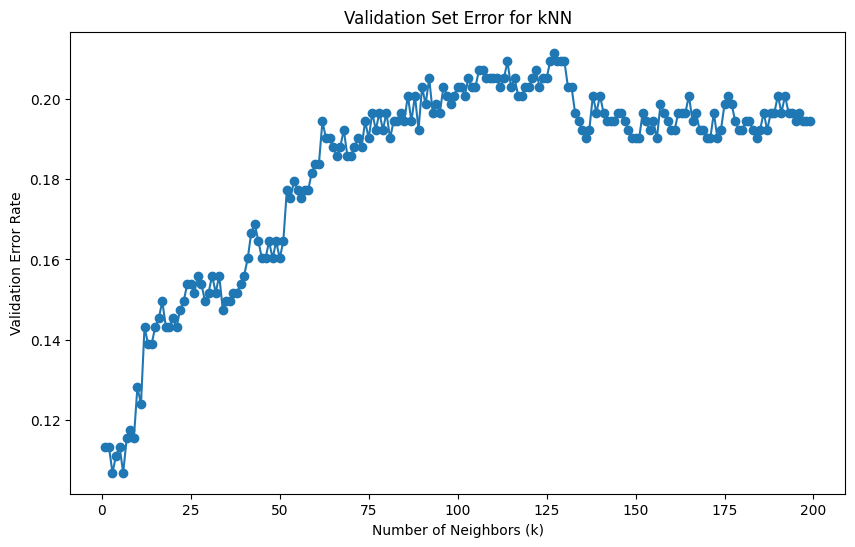

best k: 3
Confusion Matrix:
[[234  36]
 [ 30  20]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       270
           1       0.36      0.40      0.38        50

    accuracy                           0.79       320
   macro avg       0.62      0.63      0.63       320
weighted avg       0.80      0.79      0.80       320

Accuracy: 0.7937


In [ ]:
### find k, kNN_resampled

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

np.random.seed(1)
N = len(X_train_resampled)
M = int(np.ceil(0.7 * N))
idx = np.random.permutation(N)

X_train_split = X_train_scaled[idx[:M], :]
X_val_split = X_train_scaled[idx[M:], :]
y_train_split = y_train_resampled.iloc[idx[:M]]
y_val_split = y_train_resampled.iloc[idx[M:]]

misclassification = []
K = np.arange(1, 200)

for k in K:
    kNN_resampled = KNeighborsClassifier(n_neighbors=k)
    kNN_resampled.fit(X_train_split, y_train_split)
    prediction = kNN_resampled.predict(X_val_split)
    misclassification.append(np.mean(prediction != y_val_split))

plt.figure(figsize=(10, 6))
plt.plot(K, misclassification, marker='o')
plt.title('Validation Set Error for kNN')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Validation Error Rate')
plt.show()

best_k = K[np.argmin(misclassification)]
print(f"best k: {best_k}")

knn_best_resampled = KNeighborsClassifier(n_neighbors=best_k)
knn_best_resampled.fit(X_train_scaled, y_train_resampled)

y_pred = knn_best_resampled.predict(X_test_scaled)

test(knn_best_resampled, X_train_scaled, y_train_resampled, X_test_scaled, y_test)

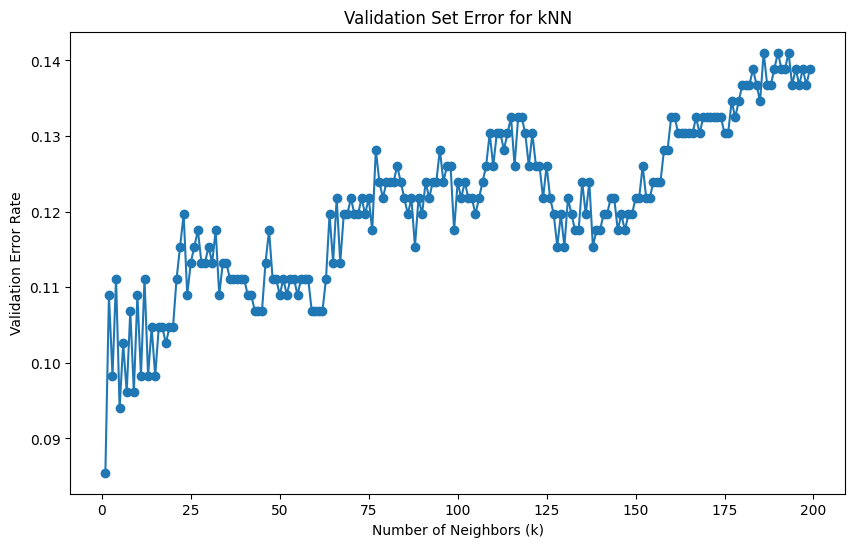

best k: 1
Confusion Matrix:
[[237  33]
 [ 28  22]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       270
           1       0.40      0.44      0.42        50

    accuracy                           0.81       320
   macro avg       0.65      0.66      0.65       320
weighted avg       0.82      0.81      0.81       320

Accuracy: 0.8094


In [ ]:
### find k, kNN_new

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_new)
X_test_scaled = scaler.transform(X_test_new)

np.random.seed(1)
N = len(X_train_new)
M = int(np.ceil(0.7 * N))
idx = np.random.permutation(N)

X_train_split = X_train_scaled[idx[:M], :]
X_val_split = X_train_scaled[idx[M:], :]
y_train_split = y_train_resampled.iloc[idx[:M]]
y_val_split = y_train_resampled.iloc[idx[M:]]


misclassification = []
K = np.arange(1, 200)

for k in K:
    kNN_resample_features = KNeighborsClassifier(n_neighbors=k)
    kNN_resample_features.fit(X_train_split, y_train_split)
    prediction = kNN_resample_features.predict(X_val_split)
    misclassification.append(np.mean(prediction != y_val_split))

plt.figure(figsize=(10, 6))
plt.plot(K, misclassification, marker='o')
plt.title('Validation Set Error for kNN')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Validation Error Rate')
plt.show()

best_k = K[np.argmin(misclassification)]
print(f"best k: {best_k}")

knn_best_new = KNeighborsClassifier(n_neighbors=best_k)
knn_best_new.fit(X_train_scaled, y_train_resampled)

y_pred = knn_best_new.predict(X_test_scaled)

test(knn_best_new, X_train_scaled, y_train_resampled, X_test_scaled, y_test)

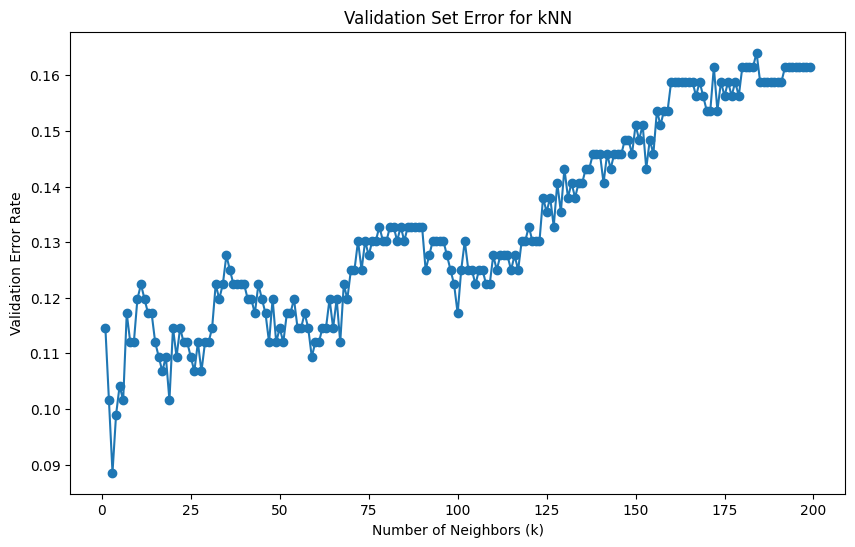

best k: 3
Confusion Matrix:
[[234  36]
 [ 30  20]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       270
           1       0.36      0.40      0.38        50

    accuracy                           0.79       320
   macro avg       0.62      0.63      0.63       320
weighted avg       0.80      0.79      0.80       320

Accuracy: 0.7937


In [ ]:
### find k, kNN_add
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_add)
X_test_scaled = scaler.transform(X_test_add)

np.random.seed(1)
N = len(X_train_add)
M = int(np.ceil(0.7 * N))
idx = np.random.permutation(N)

X_train_split = X_train_scaled[idx[:M], :]
X_val_split = X_train_scaled[idx[M:], :]
y_train_split = y_train.iloc[idx[:M]]
y_val_split = y_train.iloc[idx[M:]]

misclassification = []
K = np.arange(1, 200)

for k in K:
    kNN_features = KNeighborsClassifier(n_neighbors=k)
    kNN_features.fit(X_train_split, y_train_split)
    prediction = kNN_features.predict(X_val_split)
    misclassification.append(np.mean(prediction != y_val_split))

plt.figure(figsize=(10, 6))
plt.plot(K, misclassification, marker='o')
plt.title('Validation Set Error for kNN')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Validation Error Rate')
plt.show()

best_k = K[np.argmin(misclassification)]
print(f"best k: {best_k}")

knn_best_add = KNeighborsClassifier(n_neighbors=best_k)
knn_best_add.fit(X_train_scaled, y_train)

y_pred = knn_best_add.predict(X_test_scaled)

test(knn_best_add, X_train_scaled, y_train, X_test_scaled, y_test)

## Tree-boosting

### grid search

In [12]:
scoring = make_scorer(f1_score, average='binary', labels=[1])
xgboost_param_grid = {
    'n_estimators': [75,100,150,200],
    'max_depth': [3,4,5],
    'learning_rate': [0.1, 0.25,0.3],
    'reg_alpha': [0],
    'reg_lambda': [1],
    'subsample': [1.0],
    'colsample_bytree': [1.0]
}
xgboost_grid = GridSearchCV(
    XGBClassifier(random_state=42),
    param_grid=xgboost_param_grid,
    scoring=scoring,
    cv=3
)
xgboost_grid.fit(X_train, y_train)

print("Best Parameters for XGBoost:", xgboost_grid.best_params_)
best_xgboost = xgboost_grid.best_estimator_
test(best_xgboost,X_train, y_train,X_test,y_test)


Best Parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.25, 'max_depth': 4, 'n_estimators': 75, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1.0}
Accuracy: 0.88125
Confusion Matrix:
[[251  19]
 [ 19  31]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       270
           1       0.62      0.62      0.62        50

    accuracy                           0.88       320
   macro avg       0.77      0.77      0.77       320
weighted avg       0.88      0.88      0.88       320



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.25, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=75, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
lgbm_param_grid = {
    'n_estimators': [100,150,200],
    'max_depth': [4,5,6,7],
    'learning_rate': [0.01,0.05,0.1],
    'min_child_samples':[5],
    'subsample': [0.8],
    'colsample_bytree': [0.8, 1.0],
}
lgbm_grid = GridSearchCV(
    LGBMClassifier(random_state=42),
    param_grid=lgbm_param_grid,
    scoring=scoring,
    cv=3
)
lgbm_grid.fit(X_train, y_train)

print("Best Parameters for LightGBM:", lgbm_grid.best_params_)
best_lgbm = lgbm_grid.best_estimator_
test(best_lgbm,X_train, y_train,X_test,y_test)


流式输出内容被截断，只能显示最后 5000 行内容。
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 158, number of negative: 695
[Light

LGBMClassifier(learning_rate=0.05, max_depth=7, min_child_samples=5,
               random_state=42, subsample=0.8)

In [ ]:

adaboost_param_grid = {
    'n_estimators': [80],
    'learning_rate': [ 0.1,0.2,],
    'estimator': [
        DecisionTreeClassifier(max_depth=1),
        DecisionTreeClassifier(max_depth=3)
    ]
}

scoring = make_scorer(f1_score, average=None, labels=[1])

adaboost_grid = GridSearchCV(
    AdaBoostClassifier(random_state=42),
    param_grid=adaboost_param_grid,
    scoring=scoring,
    cv=3
)
adaboost_grid.fit(X_train, y_train)

print("Best Parameters for AdaBoost:", adaboost_grid.best_params_)
best_adaboost = adaboost_grid.best_estimator_
test(best_adaboost,X_train, y_train,X_test,y_test)


Best Parameters for AdaBoost: {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.2, 'n_estimators': 80}
Accuracy: 0.878125
Confusion Matrix:
[[249  21]
 [ 18  32]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       270
           1       0.60      0.64      0.62        50

    accuracy                           0.88       320
   macro avg       0.77      0.78      0.77       320
weighted avg       0.88      0.88      0.88       320



AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.2, n_estimators=80, random_state=42)

### resampling data set

In [21]:

best_params_xgboost = {
    'colsample_bytree': 1.0,
    'learning_rate': 0.25,
    'max_depth': 4,
    'n_estimators': 75,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'subsample': 1.0
}

model = XGBClassifier(**xgboost_grid.best_params_, random_state=42)
XGB_smote=test(model,X_train_resampled,y_train_resampled, X_test, y_test)


Accuracy: 0.853125
Confusion Matrix:
[[239  31]
 [ 16  34]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       270
           1       0.52      0.68      0.59        50

    accuracy                           0.85       320
   macro avg       0.73      0.78      0.75       320
weighted avg       0.87      0.85      0.86       320



In [19]:
##
model_LGBM=LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    random_state=42,
    eval_metric='logloss',
    min_child_samples= 4
)
LGBM_smote=test(model_LGBM,X_train_resampled, y_train_resampled,X_test,y_test)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 521, number of negative: 1042
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1408
[LightGBM] [Info] Number of data points in the train set: 1563, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

In [20]:
adaboost_model_resampled = AdaBoostClassifier(n_estimators=80,learning_rate=0.2, random_state=42)
test(adaboost_model_resampled,X_train_resampled, y_train_resampled,X_test,y_test)

Accuracy: 0.84375
Confusion Matrix:
[[231  39]
 [ 11  39]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       270
           1       0.50      0.78      0.61        50

    accuracy                           0.84       320
   macro avg       0.73      0.82      0.76       320
weighted avg       0.88      0.84      0.86       320



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(learning_rate=0.2, n_estimators=80, random_state=42)

### New data set

In [22]:
model_new = XGBClassifier(**xgboost_grid.best_params_, random_state=42)
XGB_new=test(model_new,X_train_new,y_train_resampled, X_test_new, y_test)

Accuracy: 0.85625
Confusion Matrix:
[[240  30]
 [ 16  34]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       270
           1       0.53      0.68      0.60        50

    accuracy                           0.86       320
   macro avg       0.73      0.78      0.75       320
weighted avg       0.87      0.86      0.86       320



In [ ]:
model_LGBM_new=LGBMClassifier(
    n_estimators=75,
    learning_rate=0.05,
    max_depth=4,
    random_state=42,
    eval_metric='logloss',
    min_child_samples= 4
)
LGBM_new=test(model_LGBM_new,X_train_new,y_train_resampled, X_test_new, y_test)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 521, number of negative: 1042
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2250
[LightGBM] [Info] Number of data points in the train set: 1563, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

In [ ]:
adaboost_model_new = AdaBoostClassifier(n_estimators=80,learning_rate=0.2, random_state=42)
test(adaboost_model_new,X_train_new,y_train_resampled, X_test_new, y_test)

Accuracy: 0.825
Confusion Matrix:
[[226  44]
 [ 12  38]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       270
           1       0.46      0.76      0.58        50

    accuracy                           0.82       320
   macro avg       0.71      0.80      0.73       320
weighted avg       0.87      0.82      0.84       320



AdaBoostClassifier(learning_rate=0.2, n_estimators=80, random_state=42)

### Add data set

In [23]:
model_add = XGBClassifier(**xgboost_grid.best_params_, random_state=42)
XGB_new=test(model_add,X_train_add,y_train, X_test_add, y_test)

Accuracy: 0.8875
Confusion Matrix:
[[252  18]
 [ 18  32]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       270
           1       0.64      0.64      0.64        50

    accuracy                           0.89       320
   macro avg       0.79      0.79      0.79       320
weighted avg       0.89      0.89      0.89       320



In [ ]:
model_LGBM_add=LGBMClassifier(
    n_estimators=75,
    learning_rate=0.05,
    max_depth=4,
    random_state=42,
    eval_metric='logloss',
    min_child_samples= 4
)
LGBM_add=test(model_LGBM_add,X_train_new,y_train_resampled, X_test_new, y_test)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 521, number of negative: 1042
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2250
[LightGBM] [Info] Number of data points in the train set: 1563, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

In [ ]:
adaboost_model_add = AdaBoostClassifier(n_estimators=80,learning_rate=0.2, random_state=42)
test(adaboost_model_add,X_train_add,y_train, X_test_add, y_test)

Accuracy: 0.859375
Confusion Matrix:
[[253  17]
 [ 28  22]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       270
           1       0.56      0.44      0.49        50

    accuracy                           0.86       320
   macro avg       0.73      0.69      0.71       320
weighted avg       0.85      0.86      0.85       320



AdaBoostClassifier(learning_rate=0.2, n_estimators=80, random_state=42)

### Cross Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score, accuracy_score
import numpy as np

# Define the models and their names
models = [adaboost_model_add, model_add, best_xgboost]
model_names = ['ada_add', 'xgb_add', 'xgb_base']

# Set up 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store the scores for each model
model_scores = {}

# Use binary F1-score and accuracy as evaluation metrics
f1_scoring = make_scorer(f1_score, average='binary', labels=[1])
accuracy_scoring = make_scorer(accuracy_score)

# Perform cross-validation for each model
for model, name in zip(models, model_names):
    # Compute F1 scores
    cv_f1_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=f1_scoring)

    # Compute accuracy scores
    cv_accuracy_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=accuracy_scoring)

    # Store the cross-validation scores for each model
    model_scores[name] = {'f1_scores': cv_f1_scores, 'accuracy_scores': cv_accuracy_scores}

    # Print the cross-validation scores and their means for each model
    print(f"{name} - Cross-validation F1 Scores: {cv_f1_scores}")
    print(f"{name} - Mean CV F1 Score: {np.mean(cv_f1_scores)}")
    print(f"{name} - Cross-validation Accuracy Scores: {cv_accuracy_scores}")
    print(f"{name} - Mean CV Accuracy: {np.mean(cv_accuracy_scores)}\n")

# Select the best model based on the average F1 score
best_model_name = max(model_scores, key=lambda x: np.mean(model_scores[x]['f1_scores']))
print(f"Best model based on CV F1 score: {best_model_name}")


## Tree-based methods: classification trees, random forests, bagging

In [ ]:
preprocessor=PreProcessor('training_data_fall2024.csv')
preprocessor.basicProcessing()
preprocessor.describe()
preprocessor.drop_data(col_name='snow')
preprocessor.categoryVar()
preprocessor.scaler() # Standardize numerical features
preprocessor.devideTrainingAndTesting()

Data=preprocessor.getData()
train_data,test_data=preprocessor.getTrainData(),preprocessor.getTestData()

X_train = train_data.drop('increase_stock', axis=1)
y_train = train_data['increase_stock']
X_test = test_data.drop('increase_stock', axis=1)
y_test = test_data['increase_stock']

Data loaded successfully.
Missing values removed and index reset.
Label column 'increase_stock' encoded successfully.
       hour_of_day  day_of_week        month      holiday      weekday  \
count   1600.00000  1600.000000  1600.000000  1600.000000  1600.000000   
mean      11.37125     3.022500     6.468750     0.033125     0.710000   
std        6.94837     2.012965     3.454741     0.179019     0.453904   
min        0.00000     0.000000     1.000000     0.000000     0.000000   
25%        5.00000     1.000000     3.000000     0.000000     0.000000   
50%       12.00000     3.000000     6.000000     0.000000     1.000000   
75%       17.00000     5.000000     9.000000     0.000000     1.000000   
max       23.00000     6.000000    12.000000     1.000000     1.000000   

       summertime         temp          dew     humidity       precip    snow  \
count  1600.00000  1600.000000  1600.000000  1600.000000  1600.000000  1600.0   
mean      0.64375    15.210313     7.750750    63.927

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# define a function to evaluate models
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")

    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

### Grid search on original dataset

In [ ]:
# Import necessary libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid for DecisionTreeClassifier
params = {
    "criterion": ("gini", "entropy", "log_loss"),  # Criteria to measure the quality of splits
    "splitter": ("best", "random"),  # Strategy to choose the split at each node
    "max_depth": [None, 2, 5, 10, 20],  # Maximum depth of the tree; None means unlimited depth
    "min_samples_split": [2, 3, 4],  # Minimum number of samples required to split an internal node
    "min_samples_leaf": list(range(1, 20)),  # Minimum number of samples required at a leaf node
}

# Initialize the DecisionTreeClassifier with a fixed random state for reproducibility
tree_clf = DecisionTreeClassifier(random_state=42)

# Perform Grid Search Cross Validation to tune hyperparameters
tree_cv = GridSearchCV(
    tree_clf,       # Model to tune
    params,         # Hyperparameter grid
    scoring="f1",   # Evaluation metric (F1 score for classification tasks)
    n_jobs=-1,      # Use all available CPU cores to speed up the process
    verbose=1,      # Print progress messages during execution
    cv=5            # Number of cross-validation folds
)

# Fit the model using the training data
tree_cv.fit(X_train, y_train)

# Retrieve the best hyperparameters from the grid search
best_params = tree_cv.best_params_
print(f"Best parameters: {best_params}")

# Train the model on the full training data using the best hyperparameters
tree_clf = tree_cv.best_estimator_
tree_clf.fit(X_train, y_train)
# Evaluate the model using a custom print_score function
# Evaluate performance on the training set
print_score(tree_clf, X_train, y_train, X_test, y_test, train=True)

# Evaluate performance on the test set
print_score(tree_clf, X_train, y_train, X_test, y_test, train=False)


Fitting 5 folds for each of 1710 candidates, totalling 8550 fits
Best parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 19, 'min_samples_split': 2, 'splitter': 'best'}
Train Result:
Accuracy Score: 90.70%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.939943    0.757576  0.907031     0.848759      0.906034
recall        0.946257    0.735294  0.907031     0.840776      0.907031
f1-score      0.943089    0.746269  0.907031     0.844679      0.906493
support    1042.000000  238.000000  0.907031  1280.000000   1280.000000
_______________________________________________
Confusion Matrix: 
 [[986  56]
 [ 63 175]]

Test Result:
Accuracy Score: 86.88%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.928571   0.574074   0.86875    0.751323      0.873181
recall 

In [ ]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Create a parameter grid to search over
params_grid = {
    'n_estimators': [100, 500, 1000, 1500],       # Number of trees
    'max_features': ['auto', 'sqrt'] ,       # Features considered at each split
    'max_depth': [None, 2, 5, 10, 20],             # Tree depth
    'min_samples_split': [2, 5, 10] ,  # Minimum samples to split
    'min_samples_leaf': [1, 2, 4, 10],    # Minimum samples at leaf
    'bootstrap': [True, False]              # Bootstrap sampling
}

# Initialize the RandomForestClassifier with a fixed random state for reproducibility
rf_clf = RandomForestClassifier(random_state=42)

# Perform Grid Search Cross Validation to tune hyperparameters
rf_cv = GridSearchCV(
    rf_clf,              # Model to tune
    params_grid,         # Hyperparameter grid
    scoring="f1",        # Evaluation metric: F1 score
    cv=5,                # 5-fold cross-validation
    verbose=1,           # Print progress messages during execution
    n_jobs=-1            # Use all available CPU cores for faster computation
)

# Fit the GridSearchCV to the training data
rf_cv.fit(X_train, y_train)

# Retrieve the best hyperparameters found during grid search
best_params = rf_cv.best_params_
print(f"Best parameters: {best_params}")

# Train the final RandomForestClassifier using the best hyperparameters
rf_clf = rf_cv.best_estimator_
rf_clf.fit(X_train, y_train)                    # Train on the training data

# Evaluate the model performance using a custom print_score function
# Performance on the training set
print_score(rf_clf, X_train, y_train, X_test, y_test, train=True)

# Performance on the test set
print_score(rf_clf, X_train, y_train, X_test, y_test, train=False)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits
Best parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000}
Train Result:
Accuracy Score: 99.84%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.998084    1.000000  0.998437     0.999042      0.998440
recall        1.000000    0.991597  0.998437     0.995798      0.998437
f1-score      0.999041    0.995781  0.998437     0.997411      0.998435
support    1042.000000  238.000000  0.998437  1280.000000   1280.000000
_______________________________________________
Confusion Matrix: 
 [[1042    0]
 [   2  236]]

Test Result:
Accuracy Score: 87.81%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.926199   0.612245  0.878125    

In [ ]:
# Import necessary libraries
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Initialize the base model: DecisionTreeClassifier
# This can be replaced with any other base estimator (e.g., LogisticRegression, SVM)
base_model = DecisionTreeClassifier(random_state=42)

# Initialize the BaggingClassifier with the base model
bagging_clf = BaggingClassifier(estimator=base_model, random_state=42)

# Define the hyperparameter grid for BaggingClassifier
params = {
    'n_estimators': [10, 50, 100],           # Number of base estimators (trees) in the ensemble
    'max_samples': [0.5, 0.7, 1.0],          # Proportion of samples to train each base estimator
    'max_features': [0.5, 0.7, 1.0],         # Proportion of features to train each base estimator
    'bootstrap': [True, False],              # Whether to use bootstrap sampling for samples
    'bootstrap_features': [True, False]      # Whether to use bootstrap sampling for features
}

# Perform Grid Search Cross Validation to tune hyperparameters
bagging_cv = GridSearchCV(
    bagging_clf,      # Bagging classifier model
    params,           # Hyperparameter grid
    scoring="f1",     # Evaluation metric: F1 score
    n_jobs=-1,        # Use all available CPU cores for faster computation
    verbose=1,        # Print progress messages during execution
    cv=5              # Number of cross-validation folds
)

# Fit the GridSearchCV to the training data
bagging_cv.fit(X_train, y_train)

# Retrieve the best hyperparameters found during grid search
best_params = bagging_cv.best_params_
print(f"Best parameters: {best_params}")

# Train the final BaggingClassifier using the best hyperparameters
bagging_clf = bagging_cv.best_estimator_
bagging_clf.fit(X_train, y_train)          # Train on the training data

# Evaluate the model performance using a custom print_score function
# Performance on the training set
print_score(bagging_clf, X_train, y_train, X_test, y_test, train=True)

# Performance on the test set
print_score(bagging_clf, X_train, y_train, X_test, y_test, train=False)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 0.7, 'n_estimators': 100}
Train Result:
Accuracy Score: 99.69%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.997126    0.995763  0.996875     0.996445      0.996873
recall        0.999040    0.987395  0.996875     0.993218      0.996875
f1-score      0.998082    0.991561  0.996875     0.994822      0.996870
support    1042.000000  238.000000  0.996875  1280.000000   1280.000000
_______________________________________________
Confusion Matrix: 
 [[1041    1]
 [   3  235]]

Test Result:
Accuracy Score: 87.50%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.929104   0.596154     0.875    0.762629      0.877081


### Train on resampled dataset

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Print the original class distribution
print("Original class distribution:", Counter(y_train))

# Apply SMOTE for oversampling
# sampling_strategy=0.5 means the minority class will have samples equal to 50% of the majority class
smote = SMOTE(random_state=42, sampling_strategy=0.5)

# Perform resampling on the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Print the new class distribution after applying SMOTE
print("Resampled class distribution:", Counter(y_train_resampled))

Original class distribution: Counter({0: 1042, 1: 238})
Resampled class distribution: Counter({0: 1042, 1: 521})


In [ ]:
# Train the decision tree model on resampled dataset using the best hyperparameters
best_params = {
    'random_state': 42,
    "criterion":"entropy",
    "splitter":"best",
    "max_depth":5,
    "min_samples_split":2,
    "min_samples_leaf":19,
}

tree_clf_over = DecisionTreeClassifier(**best_params)
tree_clf_over.fit(X_train_resampled, y_train_resampled)
print_score(tree_clf_over, X_train_resampled, y_train_resampled, X_test, y_test, train=True)
print_score(tree_clf_over, X_train_resampled, y_train_resampled, X_test, y_test, train=False)

Train Result:
Accuracy Score: 86.95%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.937370    0.761983  0.869482     0.849676      0.878908
recall        0.861804    0.884837  0.869482     0.873321      0.869482
f1-score      0.898000    0.818828  0.869482     0.858414      0.871609
support    1042.000000  521.000000  0.869482  1563.000000   1563.000000
_______________________________________________
Confusion Matrix: 
 [[898 144]
 [ 60 461]]

Test Result:
Accuracy Score: 80.94%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.933610   0.430380  0.809375    0.681995      0.854980
recall       0.833333   0.680000  0.809375    0.756667      0.809375
f1-score     0.880626   0.527132  0.809375    0.703879      0.825393
support    270.000000  50.000000  0.809375  320.000000   

In [ ]:
# Train the rain forests model on resampled dataset using the best hyperparameters
best_params = {
    'random_state': 42,
    'n_estimators': 100,
    'max_features': 'sqrt',
    'max_depth': 20,
    'min_samples_split': 2,
    'min_samples_leaf': 2,
    'bootstrap': False
}

rf_clf_over = RandomForestClassifier(**best_params)
rf_clf_over.fit(X_train_resampled, y_train_resampled)
print_score(rf_clf_over, X_train_resampled, y_train_resampled, X_test, y_test, train=True)
print_score(rf_clf_over, X_train_resampled, y_train_resampled, X_test, y_test, train=False)


Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                0      1  accuracy  macro avg  weighted avg
precision     1.0    1.0       1.0        1.0           1.0
recall        1.0    1.0       1.0        1.0           1.0
f1-score      1.0    1.0       1.0        1.0           1.0
support    1042.0  521.0       1.0     1563.0        1563.0
_______________________________________________
Confusion Matrix: 
 [[1042    0]
 [   0  521]]

Test Result:
Accuracy Score: 87.19%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.932075   0.581818  0.871875    0.756947      0.877348
recall       0.914815   0.640000  0.871875    0.777407      0.871875
f1-score     0.923364   0.609524  0.871875    0.766444      0.874327
support    270.000000  50.000000  0.871875  320.000000    320.000000
___________________________________________

In [ ]:
# Train the bagging model on resampled dataset using the best hyperparameters
best_params = {
    'random_state': 42,
    'n_estimators': 50,
    'max_samples': 0.7,
    'max_features': 1,
    'bootstrap':False,
    'bootstrap_features': False
}

bagging_clf_over = BaggingClassifier(**best_params)
bagging_clf_over.fit(X_train_resampled, y_train_resampled)
print_score(bagging_clf_over, X_train_resampled, y_train_resampled, X_test, y_test, train=True)
print_score(bagging_clf_over, X_train_resampled, y_train_resampled, X_test, y_test, train=False)

Train Result:
Accuracy Score: 82.79%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.794813    1.000000  0.827895     0.897407      0.863209
recall        1.000000    0.483685  0.827895     0.741843      0.827895
f1-score      0.885678    0.652005  0.827895     0.768842      0.807787
support    1042.000000  521.000000  0.827895  1563.000000   1563.000000
_______________________________________________
Confusion Matrix: 
 [[1042    0]
 [ 269  252]]

Test Result:
Accuracy Score: 84.38%
_______________________________________________
CLASSIFICATION REPORT:
                    0     1  accuracy   macro avg  weighted avg
precision    0.843750   0.0   0.84375    0.421875      0.711914
recall       1.000000   0.0   0.84375    0.500000      0.843750
f1-score     0.915254   0.0   0.84375    0.457627      0.772246
support    270.000000  50.0   0.84375  320.000000    320.000000
_________

### Resampled dataset with new features

In [ ]:
X_train_new,X_test_new=featureEngineering(X_train_resampled, X_test)

NameError: name 'featureEngineering' is not defined

In [ ]:
best_params = {
    'random_state': 42,
    "criterion":"entropy",
    "splitter":"best",
    "max_depth":5,
    "min_samples_split":2,
    "min_samples_leaf":19,
}

tree_clf_new = DecisionTreeClassifier(**best_params)
tree_clf_new.fit(X_train_new, y_train_resampled)
print_score(tree_clf_new, X_train_new, y_train_resampled, X_test_new, y_test, train=True)
print_score(tree_clf_new, X_train_new, y_train_resampled, X_test_new, y_test, train=False)

Train Result:
Accuracy Score: 91.11%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.926346    0.878968  0.911068     0.902657      0.910553
recall        0.941459    0.850288  0.911068     0.895873      0.911068
f1-score      0.933841    0.864390  0.911068     0.899116      0.910691
support    1042.000000  521.000000  0.911068  1563.000000   1563.000000
_______________________________________________
Confusion Matrix: 
 [[981  61]
 [ 78 443]]

Test Result:
Accuracy Score: 86.25%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.937984   0.548387    0.8625    0.743186      0.877110
recall       0.896296   0.680000    0.8625    0.788148      0.862500
f1-score     0.916667   0.607143    0.8625    0.761905      0.868304
support    270.000000  50.000000    0.8625  320.000000   

In [ ]:
best_params = {
    'random_state': 42,
    'n_estimators': 100,
    'max_features': 'sqrt',
    'max_depth': 20,
    'min_samples_split': 2,
    'min_samples_leaf': 2,
    'bootstrap': False
}

rf_clf_new = RandomForestClassifier(**best_params)
rf_clf_new.fit(X_train_new, y_train_resampled)
print_score(rf_clf_new, X_train_new, y_train_resampled, X_test_new, y_test, train=True)
print_score(rf_clf_new, X_train_new, y_train_resampled, X_test_new, y_test, train=False)


Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                0      1  accuracy  macro avg  weighted avg
precision     1.0    1.0       1.0        1.0           1.0
recall        1.0    1.0       1.0        1.0           1.0
f1-score      1.0    1.0       1.0        1.0           1.0
support    1042.0  521.0       1.0     1563.0        1563.0
_______________________________________________
Confusion Matrix: 
 [[1042    0]
 [   0  521]]

Test Result:
Accuracy Score: 86.88%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.935115   0.568966   0.86875    0.752040      0.877904
recall       0.907407   0.660000   0.86875    0.783704      0.868750
f1-score     0.921053   0.611111   0.86875    0.766082      0.872624
support    270.000000  50.000000   0.86875  320.000000    320.000000
___________________________________________

In [ ]:
best_params = {
    'random_state': 42,
    'n_estimators': 50,
    'max_samples': 0.7,
    'max_features': 1,
    'bootstrap':False,
    'bootstrap_features': False
}

bagging_clf_new = BaggingClassifier(**best_params)
bagging_clf_new.fit(X_train_new, y_train_resampled)
print_score(bagging_clf_new, X_train_new, y_train_resampled, X_test_new, y_test, train=True)
print_score(bagging_clf_new, X_train_new, y_train_resampled, X_test_new, y_test, train=False)

Train Result:
Accuracy Score: 82.85%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.795420    1.000000  0.828535     0.897710      0.863613
recall        1.000000    0.485605  0.828535     0.742802      0.828535
f1-score      0.886054    0.653747  0.828535     0.769901      0.808619
support    1042.000000  521.000000  0.828535  1563.000000   1563.000000
_______________________________________________
Confusion Matrix: 
 [[1042    0]
 [ 268  253]]

Test Result:
Accuracy Score: 84.69%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.846395   1.000000  0.846875    0.923197      0.870396
recall       1.000000   0.020000  0.846875    0.510000      0.846875
f1-score     0.916808   0.039216  0.846875    0.478012      0.779684
support    270.000000  50.000000  0.846875  320.00000

### Original dataset with new features

In [ ]:
X_train_add,X_test_add=featureEngineering(X_train, X_test)

In [ ]:
best_params = {
    'random_state': 42,
    "criterion":"entropy",
    "splitter":"best",
    "max_depth":5,
    "min_samples_split":2,
    "min_samples_leaf":19,
}
tree_clf_add = DecisionTreeClassifier(**best_params)
tree_clf_add.fit(X_train_add, y_train)
print_score(tree_clf_add, X_train_add, y_train, X_test_add, y_test, train=True)
print_score(tree_clf_add, X_train_add, y_train, X_test_add, y_test, train=False)

Train Result:
Accuracy Score: 90.55%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.921317    0.812834  0.905469     0.867076      0.901146
recall        0.966411    0.638655  0.905469     0.802533      0.905469
f1-score      0.943326    0.715294  0.905469     0.829310      0.900926
support    1042.000000  238.000000  0.905469  1280.000000   1280.000000
_______________________________________________
Confusion Matrix: 
 [[1007   35]
 [  86  152]]

Test Result:
Accuracy Score: 85.00%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.905109   0.521739      0.85    0.713424      0.845208
recall       0.918519   0.480000      0.85    0.699259      0.850000
f1-score     0.911765   0.500000      0.85    0.705882      0.847426
support    270.000000  50.000000      0.85  320.00000

In [ ]:
best_params = {
    'random_state': 42,
    'n_estimators': 100,
    'max_features': 'sqrt',
    'max_depth': 20,
    'min_samples_split': 2,
    'min_samples_leaf': 2,
    'bootstrap': False
}

rf_clf_add = RandomForestClassifier(**best_params)
rf_clf_add.fit(X_train_add, y_train)
print_score(rf_clf_add, X_train_add, y_train, X_test_add, y_test, train=True)
print_score(rf_clf_add, X_train_add, y_train, X_test_add, y_test, train=False)


Train Result:
Accuracy Score: 99.92%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.999041    1.000000  0.999219     0.999521      0.999219
recall        1.000000    0.995798  0.999219     0.997899      0.999219
f1-score      0.999520    0.997895  0.999219     0.998708      0.999218
support    1042.000000  238.000000  0.999219  1280.000000   1280.000000
_______________________________________________
Confusion Matrix: 
 [[1042    0]
 [   1  237]]

Test Result:
Accuracy Score: 88.12%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.932836   0.615385   0.88125    0.774110      0.883234
recall       0.925926   0.640000   0.88125    0.782963      0.881250
f1-score     0.929368   0.627451   0.88125    0.778410      0.882193
support    270.000000  50.000000   0.88125  320.00000

In [ ]:
best_params = {
    'random_state': 42,
    'n_estimators': 50,
    'max_samples': 0.7,
    'max_features': 1,
    'bootstrap':False,
    'bootstrap_features': False
}

bagging_clf_add = BaggingClassifier(**best_params)
bagging_clf_add.fit(X_train_add, y_train)
print_score(bagging_clf_add, X_train_add, y_train, X_test_add, y_test, train=True)
print_score(bagging_clf_add, X_train_add, y_train, X_test_add, y_test, train=False)

Train Result:
Accuracy Score: 81.41%
_______________________________________________
CLASSIFICATION REPORT:
                     0      1  accuracy    macro avg  weighted avg
precision     0.814063    0.0  0.814063     0.407031      0.662698
recall        1.000000    0.0  0.814063     0.500000      0.814063
f1-score      0.897502    0.0  0.814063     0.448751      0.730623
support    1042.000000  238.0  0.814063  1280.000000   1280.000000
_______________________________________________
Confusion Matrix: 
 [[1042    0]
 [ 238    0]]

Test Result:
Accuracy Score: 84.38%
_______________________________________________
CLASSIFICATION REPORT:
                    0     1  accuracy   macro avg  weighted avg
precision    0.843750   0.0   0.84375    0.421875      0.711914
recall       1.000000   0.0   0.84375    0.500000      0.843750
f1-score     0.915254   0.0   0.84375    0.457627      0.772246
support    270.000000  50.0   0.84375  320.000000    320.000000
__________________________________

### Cross validation

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score, accuracy_score
import pandas as pd
import numpy as np

def cross_validation_evaluation(X_train, y_train, models, model_names, n_splits=5, random_state=42):
    # Define Stratified K-Fold
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Define scoring metrics
    f1_scoring = make_scorer(f1_score, average='binary')
    accuracy_scoring = make_scorer(accuracy_score)

    # Store results
    results = []

    # Perform cross-validation for each model
    for model, name in zip(models, model_names):
        # Compute F1 and Accuracy scores
        cv_f1_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=f1_scoring)
        cv_accuracy_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=accuracy_scoring)

        # Append results
        results.append({
            'Model': name,
            'Mean F1 Score': np.mean(cv_f1_scores),
            'Std F1 Score': np.std(cv_f1_scores),
            'Mean Accuracy': np.mean(cv_accuracy_scores),
            'Std Accuracy': np.std(cv_accuracy_scores)
        })

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df


In [ ]:
# original dataset
models = [tree_clf, rf_clf, bagging_clf]
model_names = ['tree', 'rf', 'bagging']

results_df = cross_validation_evaluation(X_train, y_train, models, model_names)
print(results_df)

# Select the best model based on the highest mean F1 score
best_model_name = results_df.loc[results_df['Mean F1 Score'].idxmax(), 'Model']
print(f"Best model based on CV F1 score: {best_model_name}")


In [ ]:
# resampled dataset
models = [tree_clf_over, rf_clf_over, bagging_clf_over]
model_names = ['tree', 'rf', 'bagging']

results_df = cross_validation_evaluation(X_train_resampled, y_train_resampled, models, model_names)
print(results_df)

# Select the best model based on the highest mean F1 score
best_model_name = results_df.loc[results_df['Mean F1 Score'].idxmax(), 'Model']
print(f"Best model based on CV F1 score: {best_model_name}")

In [ ]:
# resampled dataset with new features
models = [tree_clf_new, tree_clf_new, tree_clf_new]
model_names = ['tree', 'rf', 'bagging']

results_df = cross_validation_evaluation(X_train_new, y_train_resampled, models, model_names)
print(results_df)

# Select the best model based on the highest mean F1 score
best_model_name = results_df.loc[results_df['Mean F1 Score'].idxmax(), 'Model']
print(f"Best model based on CV F1 score: {best_model_name}")

In [ ]:
# original dataset with new features
models = [tree_clf_add, rf_clf_add, bagging_clf_add]
model_names = ['tree', 'rf', 'bagging']

results_df = cross_validation_evaluation(X_train_add, y_train, models, model_names)
print(results_df)

# Select the best model based on the highest mean F1 score
best_model_name = results_df.loc[results_df['Mean F1 Score'].idxmax(), 'Model']
print(f"Best model based on CV F1 score: {best_model_name}")

# Predicition

In [ ]:
pre_X=pd.read_csv('test_data_fall2024.csv')

In [ ]:
pre_X.drop(columns=['snow'],inplace=True)

In [ ]:
def featureEngineering_pred(X_test):

    X_test_new=X_test.copy()


    X_test_new['temp_humidity_interaction'] = X_test_new['temp'] * X_test_new['humidity']

    X_test_new['dew_humidity_interaction'] = X_test_new['dew'] * X_test_new['humidity']



    X_test_new['temp_squared'] = X_test_new['temp'] ** 2


    X_test_new['humidity_log'] = np.log(X_test_new['humidity'])


    X_test_new['hour_cate'] = 1
    X_test_new.loc[X_test_new['hour_of_day'].between(15, 19), 'hour_cate'] = 2
    X_test_new.loc[(X_test_new['hour_of_day'] <= 7) | (X_test_new['hour_of_day'] >= 21), 'hour_cate'] = 0


    X_test_new['month_cate'] = 2
    X_test_new.loc[X_test_new['month'].isin([0, 1, 10, 11]), 'month_cate'] = 0
    X_test_new.loc[X_test_new['month'].isin([2, 4, 6, 7]), 'month_cate'] = 1



    X_test_new['hour_sin'] = np.sin(2 * np.pi * X_test_new['hour_of_day'] / 24)
    X_test_new['hour_cos'] = np.cos(2 * np.pi * X_test_new['hour_of_day'] / 24)

    X_test_new['day_of_week_sin'] = np.sin(2 * np.pi * X_test_new['day_of_week'] / 7)
    X_test_new['day_of_week_cos'] = np.cos(2 * np.pi * X_test_new['day_of_week'] / 7)

    X_test_new['month_sin'] = np.sin(2 * np.pi * X_test_new['month'] / 2)
    X_test_new['month_cos'] = np.cos(2 * np.pi * X_test_new['month'] / 2)


    X_test_new = X_test_new.drop('dew', axis=1)

    return X_test_new

In [ ]:
pre_X_add=featureEngineering_pred(pre_X)

In [ ]:
## do some thing...